In [6]:
import cv2
import numpy as np
import SimpleITK as sitk
import pandas as pd
import pandas.tools.plotting as pdplot

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys
import os
import time
import re

import scipy.signal
import scipy.misc
import scipy.ndimage.filters

import statsmodels.api as sm

import sklearn.decomposition

import skimage.filter
import skimage.util

import angles

from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML
from detect_peaks import detect_peaks

sys.path.insert(0, 'pyLAR')
sys.path.insert(0, 'PyRPCA')

#%load_ext rmagic

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 30, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

titlesize = 20
labelsize = 15
linewidth = 4

## Utility Functions

In [7]:
def cvShowImage(imDisp, strName, strAnnotation = '', textColor=(0,0,255)):
    imDisp = cv2.cvtColor(imDisp.copy(), cv2.cv.CV_GRAY2RGB)
    
    if size(strAnnotation) > 0:
        cv2.putText(imDisp, strAnnotation, (10, 20), cv2.FONT_HERSHEY_PLAIN, 2.0, textColor, thickness=2)
        
    cv2.imshow(strName, imDisp)   
    
def mplotShowImage(imInput):
    plt.imshow(imInput, cmap=plt.cm.gray)
    plt.grid(False)
    plt.xticks(())
    plt.yticks(())
    
def normalizeArray(a):
    return (0.0 + a - a.min()) / (a.max() - a.min())    

def cvShowVideo(imVideo, strWindowName, waitTime=30, resizeAmount=None):
    
    if not isinstance(imVideo, list):
        imVideo = [imVideo]
        strWindowName = [strWindowName]
        
    # find max number of frames
    maxFrames = 0
    
    for vid in range(len(imVideo)):
        
        if imVideo[vid].shape[2] > maxFrames:
            maxFrames = imVideo[vid].shape[2]
    
    # display video
    blnLoop = True      
    fid = 0
    
    while True:
        
        for vid in range(len(imVideo)):

            curVideoFid = fid % imVideo[vid].shape[2]
            imCur = imVideo[vid][:,:,curVideoFid]

            # resize image if requested
            if resizeAmount:
                imCur = scipy.misc.imresize(imCur, resizeAmount)

            # show image
            cvShowImage(imCur, strWindowName[vid], '%d' % (curVideoFid+1))

        # look for "esc" key
        k = cv2.waitKey(waitTime) & 0xff

        if blnLoop:

            if k == 27:            
                break
            elif k == ord(' '):
                blnLoop = False
            else:
                fid = (fid + 1) % maxFrames
                
        else:
                    
            if k == 27: # escape           
                
                break
                
            elif k == ord(' '): # space
                
                blnLoop = True
                
            elif k == 81: # left arrow
                
                fid = (fid - 1) % maxFrames
                
            elif k == 83: # right arrow
                
                fid = (fid + 1) % maxFrames                
            
    for vid in range(len(imVideo)):            
        cv2.destroyAllWindows()
    
def normalizeArray(a):
    return (0.0 + a - a.min()) / (a.max() - a.min())    
    
def loadVideoFromFile(dataFilePath, sigmaSmooth=None, resizeAmount=None):
    
    vidseq = cv2.VideoCapture(dataFilePath)

    # print metadata
    metadata = {}
    
    numFrames = vidseq.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT)
    print '\tFRAME_COUNT = ', numFrames
    metadata['FRAME_COUNT'] = numFrames
    
    fps = vidseq.get(cv2.cv.CV_CAP_PROP_FPS)
    if fps > 0:
        print '\tFPS = ', fps
        metadata['FPS'] = fps

    fmt = vidseq.get(cv2.cv.CV_CAP_PROP_FORMAT)
    if fmt > 0:
        print '\FORMAT = ', fmt
        metadata['FORMAT'] = fmt
        
    vmode = vidseq.get(cv2.cv.CV_CAP_PROP_MODE)
    if vmode > 0:
        print '\MODE = ', vmode
        metadata['MODE'] = MODE
        
    # smooth if wanted
    if sigmaSmooth:        
        wSmooth = 4 * sigmaSmooth + 1            
    
    # read video frames
    imInput = []
    
    fid = 0
    prevPercent = 0
    print '\n'
    
    while True:
        valid_object, frame = vidseq.read()    
        
        if not valid_object:
            break    
             
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        if resizeAmount:
            frame = scipy.misc.imresize(frame, resizeAmount)
        
        if sigmaSmooth:        
            frame = cv2.GaussianBlur(frame, (wSmooth, wSmooth), 0)            
        if np.size(imInput) == 0:
            imInput = frame
        else:
            imInput = np.dstack((imInput, frame))            

        # update progress
        fid += 1
        curPercent = np.floor(100.0*fid/numFrames)
        if curPercent > prevPercent:
            prevPercent = curPercent
            print '%.2d%%' % curPercent, 
            
    print '\n'
    
    return (imInput, metadata)

def writeVideoToFile(imVideo, filename, codec='DIVX', fps=30):

    # start timer
    tStart = time.time()
    
    # write video
    height, width, numFrames = imVideo.shape
    fourcc = cv2.cv.FOURCC(*list(codec))    
    writer = cv2.VideoWriter(filename, fourcc, fps=fps, frameSize=(width, height), isColor=0)

    print writer.isOpened()
    for fid in range(numFrames):
        writer.write(imVideo[:,:,fid].astype('uint8'))
        
    # end timer        
    tEnd = time.time()    
    print 'Writing video {} took {} seconds'.format(filename, tEnd - tStart) 
    
    # release
    writer.release()      
    
def writeVideoAsTiffStack(imVideo, strFilePrefix):
    
    # start timer
    tStart = time.time()
    
    for fid in range(imVideo.shape[2]):
        
        plt.imsave(strFilePrefix + '.%.3d.tif' % (fid+1), imVideo[:, :, fid])

    # end timer        
    tEnd = time.time()    
    print 'Writing video {} took {} seconds'.format(strFilePrefix, tEnd - tStart) 
        
def mplotShowMIP(im, axis, xlabel=None, ylabel=None, title=None):

    plt.imshow(im.max(axis))
    
    if title:
        plt.title(title)

    if xlabel:
        plt.xlabel(xlabel)
        
    if ylabel:
        plt.ylabel(ylabel)

def convertFromRFtoBMode( imInputRF ):
    return np.abs(scipy.signal.hilbert(imInputRF, axis=0))

def normalizeAngles(angleList, angle_range):
    return np.array([angles.normalize(i, angle_range[0], angle_range[1]) for i in angleList])

def SaveFigToDisk(saveDir, fileName, saveext = ['.png', 'eps'], **kwargs):
    for ext in saveext:
        plt.savefig( os.path.join(saveDir, fileName + ext), **kwargs)

def SaveImageToDisk(im, saveDir, fileName, saveext = ['.png', 'eps']):
    for ext in saveext:
        plt.imsave( os.path.join(saveDir, fileName + ext), im )
        

## Set results root directory

In [8]:
resultsRootDir = '.'
#resultsRootDir = '/home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos'

# Load Data

## Synthetic Data - Expanding/contracting circle

In [9]:
def genCircleData(phase, minRadius, maxRadius, 
                  smoothFactor=None, stdGaussianNoise=None,
                  padFactor=0.2, linewidth=1, maxIntensity=1):
    
    assert(maxRadius > minRadius)
    
    deltaRadius = maxRadius - minRadius
    meanRadius = 0.5 * (maxRadius + minRadius)
    
    w = 2 * (maxRadius + linewidth + padFactor * deltaRadius) + 1

    imCircleGen = np.zeros((w,w, np.size(phase)))

    x, y, p = np.meshgrid(np.arange(w), np.arange(w), phase)
    
    x -= 0.5 * w
    y -= 0.5 * w    
    r = (meanRadius + 0.5 * deltaRadius * np.sin(p))    
    
    distToCenter = np.sqrt(x**2 + y**2)
    maskCircle = np.abs(distToCenter - r) <= linewidth 
    
    imCircleGen[ maskCircle ] = maxIntensity

    # smoothing
    if smoothFactor and smoothFactor > 0:
        assert(smoothFactor < 1)
        smoothAmount = smoothFactor * deltaRadius        
        imCircleGen = scipy.ndimage.filters.gaussian_filter(imCircleGen, (smoothAmount, smoothAmount, 1))       

    imCircleGen = np.squeeze(imCircleGen)
        
    # add guassian noise    
    imCircleGen_prenoise = imCircleGen
    
    if stdGaussianNoise and stdGaussianNoise > 0:
        assert(stdGaussianNoise < 1)
        imCircleGen = skimage.util.random_noise(imCircleGen, 
                                                mode='gaussian', var=(stdGaussianNoise * maxIntensity)**2, 
                                                clip=False)
        imCircleGen[imCircleGen > maxIntensity] = maxIntensity
         
    # return stuff    
    radiusAtPhase = (meanRadius + 0.5 * deltaRadius * np.sin(phase))
    
    return imCircleGen, radiusAtPhase, imCircleGen_prenoise    

In [10]:
# show sample image
def show_sample_image(smoothFactor=0.05, stdGaussianNoise=0.1):
    
    samplePhase = 90 # in degrees
    imSample, r, _ = genCircleData(np.deg2rad(samplePhase), minRadius=10, maxRadius=25, 
                                   smoothFactor=smoothFactor, maxIntensity=1, stdGaussianNoise=stdGaussianNoise)

    plt.imshow(imSample)
    plt.title('Sample Image at phase = %.2f degrees' % samplePhase )
 
#show_sample_image()    
interact(show_sample_image, smoothFactor = (0.01, 0.1, 0.01), stdGaussianNoise = (0.02, 0.2, 0.02))    

<function __main__.show_sample_image>

#### Generate video

In [11]:
# parameters
minRadius=10 
maxRadius=25
smoothFactor=0.1

numPeriods = 30
numSamplesPerPeriod = 5 * 4
phaseNoiseLevel = 0.8 # fraction of (sampling-interval / 2)
stdGaussianNoise = 0.1

resizeAmount = 4.0

# generate video
np.random.seed(1)
samplingInterval = 360 / numSamplesPerPeriod # in degrees
phaseNoiseMax = phaseNoiseLevel * (samplingInterval / 2.0)

phaseGroundtruth_prenoise = np.linspace(0, 360 * numPeriods, numSamplesPerPeriod * numPeriods, endpoint=False) % 360
phaseGroundtruth = (phaseGroundtruth_prenoise + 
                    (2 * np.random.rand(phaseGroundtruth_prenoise.size) - 1) * phaseNoiseMax) % 360
phaseGroundtruth_prenoise += -180
phaseGroundtruth += -180

imInput_highres, ts_radius_highres, imInput_highres_prenoise = genCircleData(np.deg2rad(phaseGroundtruth), 
                                                                             minRadius=minRadius, maxRadius=maxRadius, 
                                                                             smoothFactor=smoothFactor,
                                                                             stdGaussianNoise=stdGaussianNoise)

framesPerSec = numSamplesPerPeriod

#show mip
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(imInput_highres_prenoise.max(2))
plt.title('MIP of input without noise')

plt.subplot(1, 2, 2)
plt.imshow(imInput_highres.max(2))
plt.title('MIP of input with noise')

# show mid XT slice
plt.figure()

plt.subplot(2, 1, 1)
plt.imshow(imInput_highres_prenoise[:, imInput_highres_prenoise.shape[1]/2, :])
plt.title('Mid XT slice of input without noise')

plt.subplot(2, 1, 2)
plt.imshow(imInput_highres[:, imInput_highres.shape[1]/2, :])
plt.title('Mid XT slice of input with noise')

# show circle radius
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(30, 30))

l = phaseGroundtruth.size

ax[0].plot(ts_radius_highres[:l], '-o', markersize=20, linewidth=linewidth)
ax[0].set_title('Radius', fontsize=titlesize)

# show instantaneous phase
ax[1].plot(phaseGroundtruth_prenoise[:l], '-go', markersize=15, linewidth=linewidth, label='without noise')
ax[1].plot(phaseGroundtruth[:l], '-ro', markersize=20, linewidth=linewidth, label='with noise')
ax[1].set_ylim([-185, 185])
ax[1].set_title('Groundtruth Instantaneous Phase', fontsize=titlesize)
ax[1].legend()

In [12]:
# make results dir
resultsDir = os.path.join(resultsRootDir, 'VibratingCircle')
resultFilePrefix = 'VibratingCircle'

if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)
    
print 'Results store directory: ', resultsDir    

Results store directory:  ./VibratingCircle


In [13]:
# show video
cvShowVideo([normalizeArray(imInput_highres_prenoise), normalizeArray(imInput_highres)],
            ['Input Video Before Noise', 'Input Video After Noise'], resizeAmount=resizeAmount)

NameError: global name 'size' is not defined

## Load Image Data From Disk

##### Set the data root directory here

In [36]:
#dataRootDir = '../../data/SHeart-HRes-LFPS/'
#dataRootDir = '../../data/SHeart2015-01-21/'
dataRootDir = '../../data/SHeart2015-02-20-HRes-HFPS/'

# List all readable data files
dataFiles = {'prefix': [],
             'ext': [],
             'path': []}

i = 0
for f in os.listdir(dataRootDir):
    
    prefix, ext = os.path.splitext(f)
    
    if ext not in ['.mha', '.avi', '.tif']:        
        continue        
    else:
        print '%d: %s' % (i, f)        
        dataFiles['prefix'].append(prefix)
        dataFiles['ext'].append(ext)
        dataFiles['path'].append( os.path.join(dataRootDir, f) )
        i += 1    

0: Heart_20150220_150858.avi
1: Heart_20150220_151027.avi
2: Heart_20150220_151146.avi
3: Heart_20150220_151322.avi
4: Heart_20150220_151848.avi


##### Select dataset to analyze

In [37]:
xyROI = {}
downsizeAmount = None

# set parameters
if True: # high-res probe High FPS
    
    datasetId = 3     
    downsizeAmount = 0.5
    xyROI = {'min_X': np.round(250 * downsizeAmount),
             'max_X': np.round(1300 * downsizeAmount), 
             'min_Y': np.round(40 * downsizeAmount) }
    #xyROI = { 'min_X': 600, 'max_X': 1000, 'min_Y': 300, 'max_Y': 750 }
    resizeAmount = 1.0 # for opencv video display only    

if False: # high-res probe Low FPS
    
    datasetId = 2 
    resizeAmount = 0.75 # for opencv video display

if False: # Low-res probe
    
    datasetId = 7 
    framesPerSec = 10
    resizeAmount = 1.0 # for opencv video display only
    
print 'Selected dataset: ',  dataFiles['path'][datasetId]    

Selected dataset:  ../../data/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151322.avi


##### Load selected dataset

In [38]:
# load data
print "\nLoading %s: \n" % (dataFiles['path'][datasetId])

if dataFiles['ext'][datasetId] == '.mha':
    
    imInput_sitk = sitk.ReadImage( dataFiles['path'][datasetId] )
    
    print '\tImage Type: ', imInput_sitk.GetPixelIDTypeAsString()
    
    imInput_highres_uncropped = np.transpose( sitk.GetArrayFromImage( imInput_sitk ), [1, 2, 0] )      
    
    print '\tSpacing: ', np.array(imInput_sitk.GetSpacing())[ix_([1, 2, 0])]
    
elif dataFiles['ext'][datasetId] in [ '.avi', '.tif' ]:    

    imInput_highres_uncropped, metadata = loadVideoFromFile(dataFiles['path'][datasetId], resizeAmount=downsizeAmount)
    
    if dataFiles['ext'][datasetId] == '.avi':
    
        if metadata.has_key('FPS'):
            framesPerSec = metadata['FPS']
            
        pass              
            
        if metadata.has_key('FRAME_COUNT'):                           
            
            if metadata['FRAME_COUNT'] < imInput_highres_uncropped.shape[2]:
                
                numChannels = imInput_highres_uncropped.shape[2] / metadata['FRAME_COUNT']                
                print 'Video seems to be in color with %d channels' % numChannels
                imInput_highres_uncropped = imInput_highres_uncropped[:,:,::numChannels]
        pass
else:    
    raise ValueError('Unknown file type %s' % dataFiles['ext'][datasetId])

print '\tImage Size: ', imInput_highres_uncropped.shape    


Loading ../../data/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151322.avi: 

	FRAME_COUNT =  507.0
	FPS =  35.8333333333


01% 02% 03% 04% 05% 06% 07% 08% 09% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100% 

	Image Size:  (434, 777, 507)


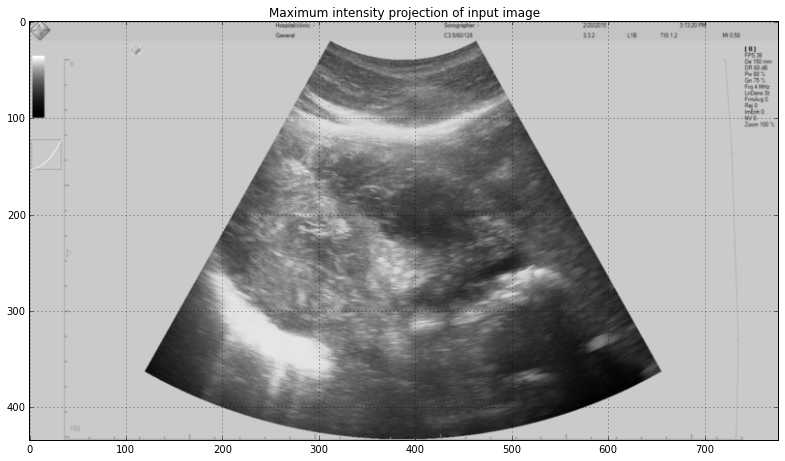

In [39]:
# show mip
plt.figure()
plt.imshow(imInput_highres_uncropped.max(2))
plt.title('Maximum intensity projection of input image')


Image Size After Cropping:  (414, 525, 507)


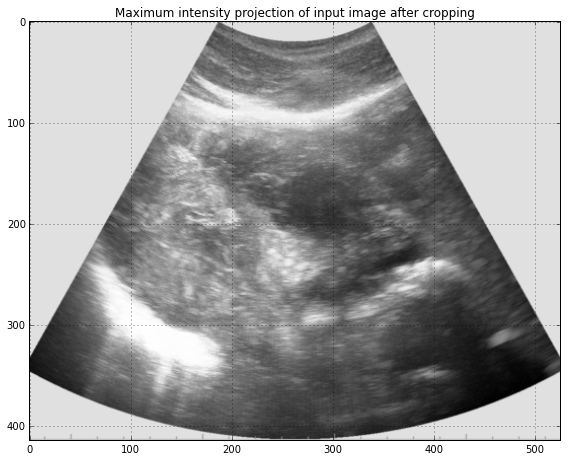

In [40]:
# crop if requested
xBounds = [0, imInput_highres_uncropped.shape[1]]

if xyROI.has_key('min_X'):
    xBounds[0] = xyROI['min_X']    
if xyROI.has_key('max_X'):    
    xBounds[1] = xyROI['max_X']

yBounds = [0, imInput_highres_uncropped.shape[0]]

if xyROI.has_key('min_Y'):
    yBounds[0] = xyROI['min_Y']    
if xyROI.has_key('max_Y'):    
    yBounds[1] = xyROI['max_Y']
    
imInput_highres = imInput_highres_uncropped[yBounds[0]:yBounds[1], xBounds[0]:xBounds[1], :] 
imInput_highres_prenoise = imInput_highres

print '\nImage Size After Cropping: ', imInput_highres.shape

# show mip
plt.figure()
plt.imshow(imInput_highres.max(2))
plt.title('Maximum intensity projection of input image after cropping')

In [33]:
# show video
cvShowVideo(normalizeArray(imInput_highres), 'Input Video', resizeAmount=resizeAmount)

In [41]:
# make results dir
resultFilePrefix = dataFiles['prefix'][datasetId]

resultsDir = os.path.join(resultsRootDir, 
                          os.path.split( os.path.abspath(dataRootDir) )[1], 
                          dataFiles['prefix'][datasetId])
if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)
    
print 'Results store directory: ', resultsDir    

Results store directory:  ./SHeart2015-02-20-HRes-HFPS/Heart_20150220_151322


# Artificially downsample the data along the time dimension

In [42]:
#set parameters
timeDownsamplingFrameStep = 3

assert(timeDownsamplingFrameStep >= 1 and (timeDownsamplingFrameStep - np.floor(timeDownsamplingFrameStep) == 0))
       
# downsample the data by the specified amount
imInput = imInput_highres[:, :, ::timeDownsamplingFrameStep]

framesPerSecDownsmp = framesPerSec * (1.0 / timeDownsamplingFrameStep)

print '\nImage Size before downsampling in time: ', imInput_highres.shape
print 'Image Size after downsampling in time: ', imInput.shape

print '\nFrames per sec before downsampling in time: ', framesPerSec
print 'Frames per sec after downsampling in time: ', framesPerSecDownsmp


Image Size before downsampling in time:  (414, 525, 507)
Image Size after downsampling in time:  (414, 525, 169)

Frames per sec before downsampling in time:  35.8333333333
Frames per sec after downsampling in time:  11.9444444444


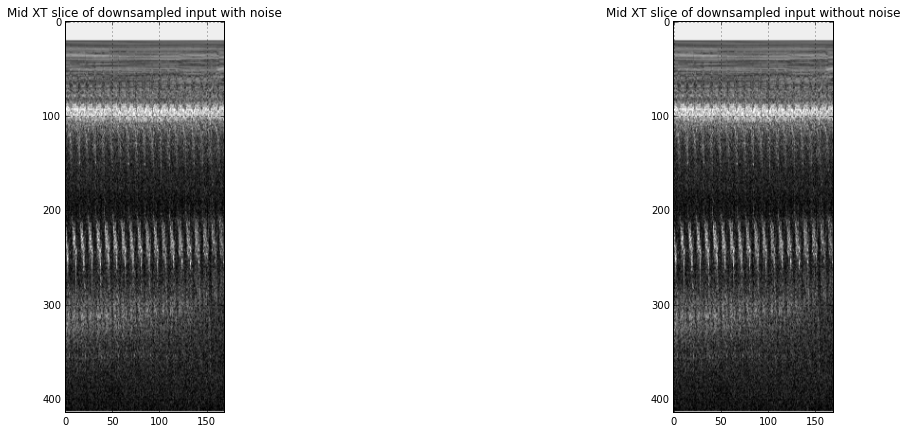

In [44]:
# show mid XT slice of downsampled input before and after noise
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.imshow(imInput[:, imInput.shape[1]/2, :])
plt.title('Mid XT slice of downsampled input with noise')

plt.subplot(122)
plt.imshow(imInput_highres_prenoise[:, imInput.shape[1]/2, ::timeDownsamplingFrameStep])
plt.title('Mid XT slice of downsampled input without noise')


In [11]:
cvShowVideo([normalizeArray(imInput_highres), normalizeArray(imInput)],
            ['Input high-res video', 'Input artifical low-res video'], resizeAmount=resizeAmount)

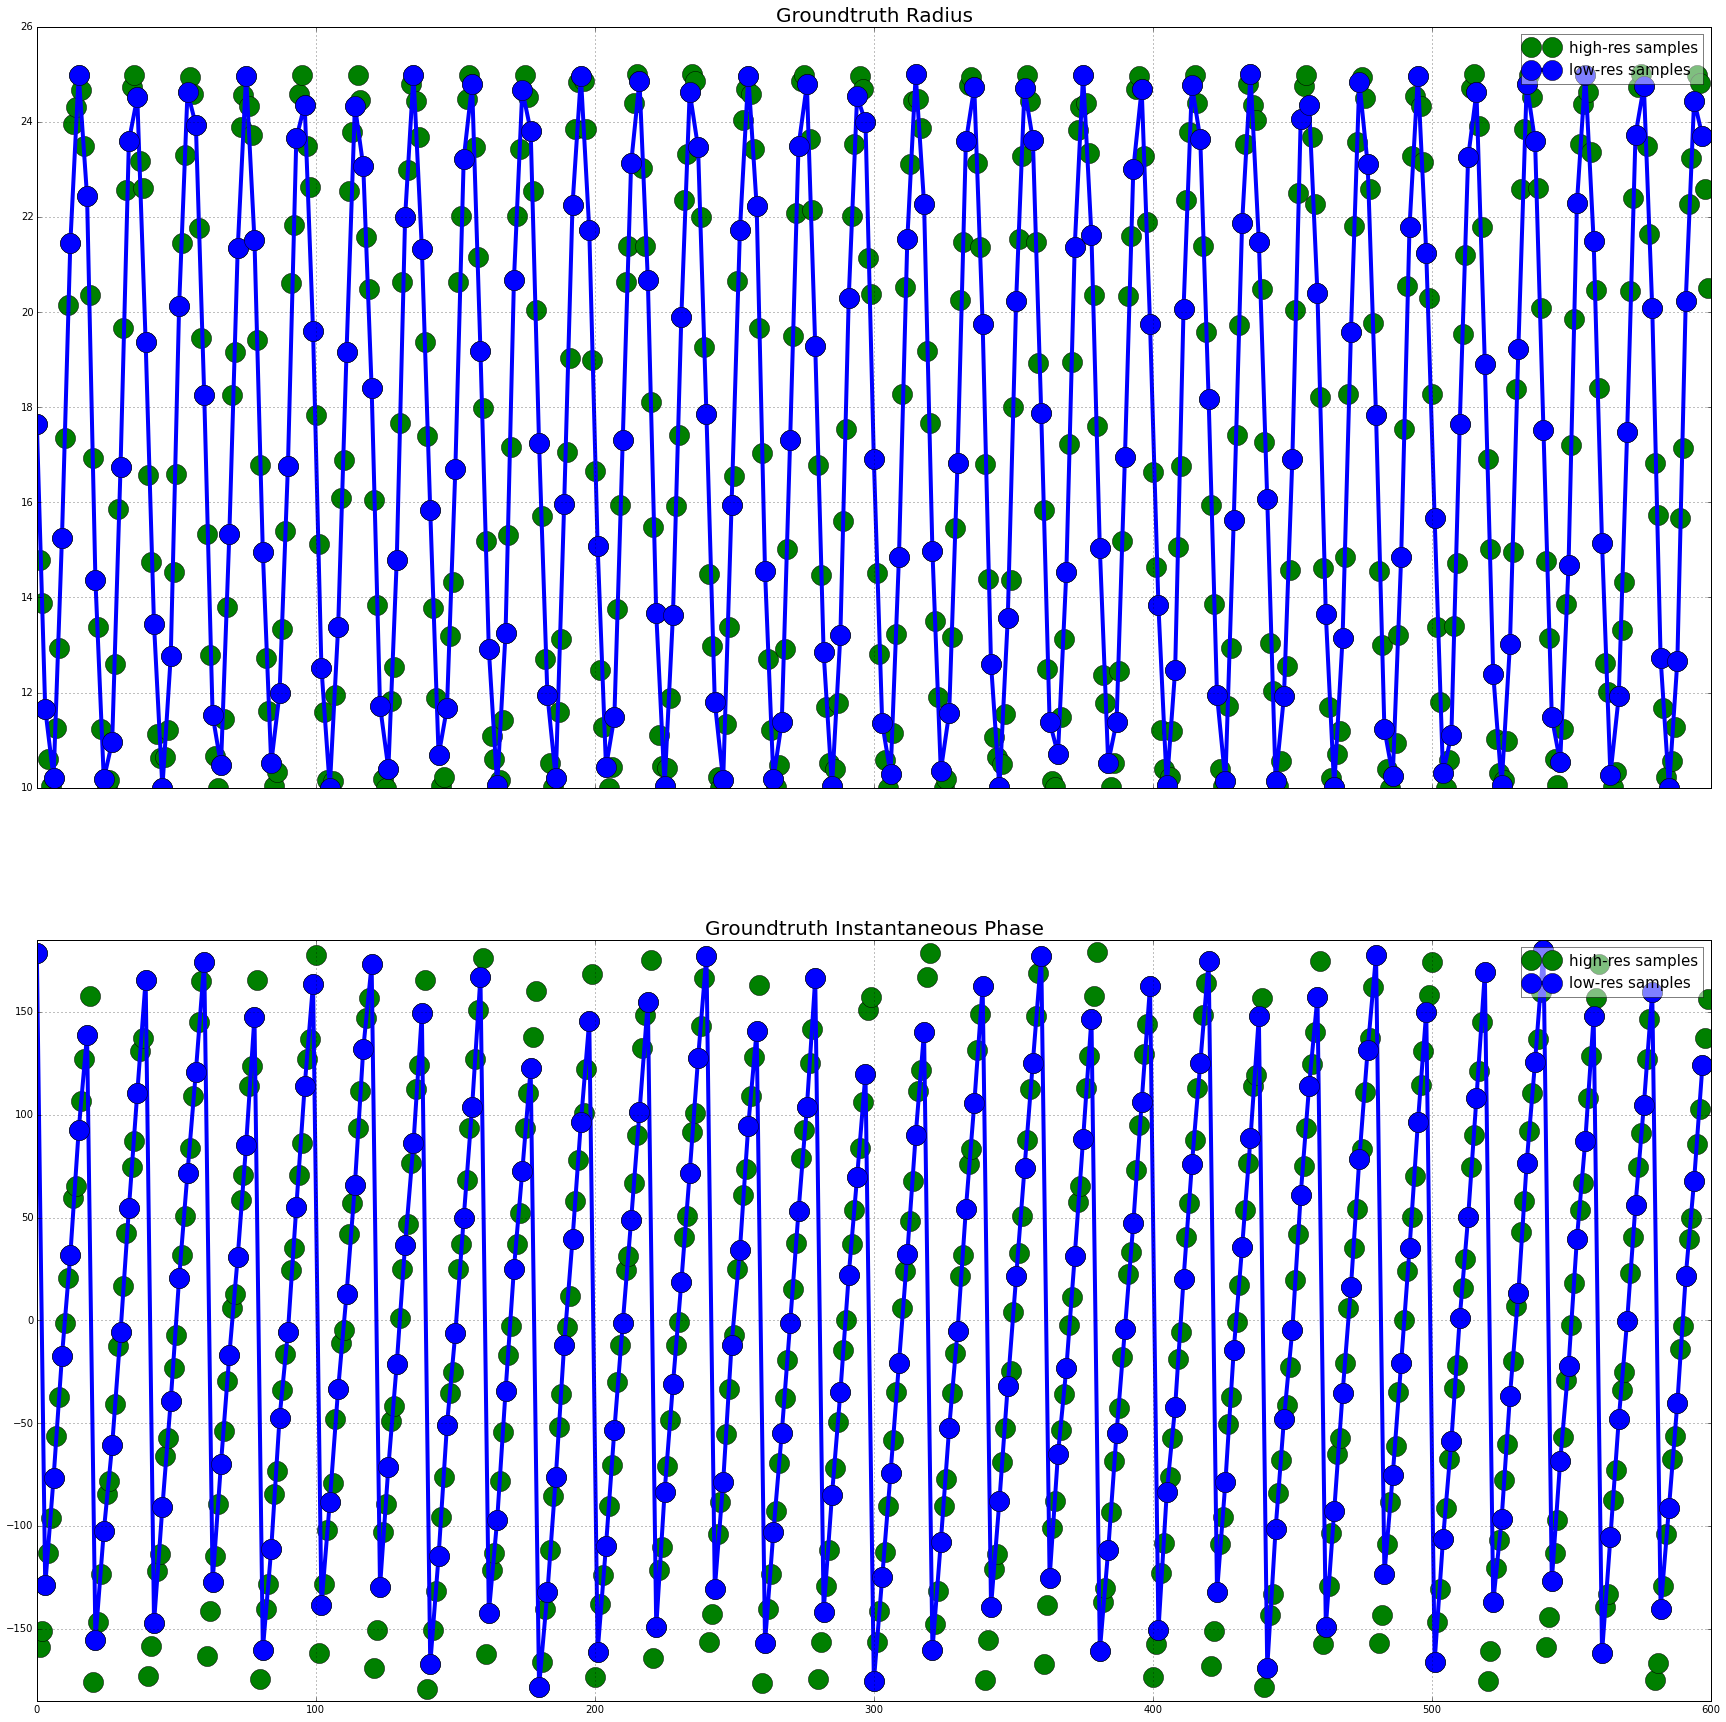

In [45]:
if all(k in locals() for k in ['ts_radius_highres', 'phaseGroundtruth']):
    
    # show circle radius
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(30, 30))
    
    t = np.arange(ts_radius_highres.size)
    ax[0].plot(t, ts_radius_highres, 'go', 
               markersize=20, linewidth=linewidth, label='high-res samples')
    ax[0].plot(t[::timeDownsamplingFrameStep], ts_radius_highres[::timeDownsamplingFrameStep], '-bo', 
               markersize=20, linewidth=linewidth, label='low-res samples')
    ax[0].set_title('Groundtruth Radius', fontsize=titlesize)
    ax[0].legend(fontsize=labelsize, framealpha=0.5)

    # show instantaneous phase
    ax[1].plot(t, phaseGroundtruth, 'go', 
               markersize=20, linewidth=linewidth, label='high-res samples')
    ax[1].plot(t[::timeDownsamplingFrameStep], phaseGroundtruth[::timeDownsamplingFrameStep], '-bo', 
               markersize=20, linewidth=linewidth, label='low-res samples')
    ax[1].set_ylim([-185, 185])
    ax[1].set_title('Groundtruth Instantaneous Phase', fontsize=titlesize)
    ax[1].legend(fontsize=labelsize, framealpha=0.5)

# Algorithm

### Run the algorithm

In [46]:
import USGatingAndSuperResolution as superUS
algo = superUS.USGatingAndSuperResolution(xyDownsamplingFactor=0.5)
algo.process(imInput)


>> Step-1: Suppressing noise using low-rank plus sparse decomposition ...

[iter: 0000]: rank(P) = 0001, |C|_0 = 0000, crit=1.0751718929, total sparse =0000
[iter: 0010]: rank(P) = 0011, |C|_0 = 2336758, crit=0.2525448378, total sparse =30337130
[iter: 0020]: rank(P) = 0022, |C|_0 = 5754092, crit=0.0009972108, total sparse =44373796
[iter: 0030]: rank(P) = 0024, |C|_0 = 5910123, crit=0.0000097480, total sparse =44386620
[iter: 0040]: rank(P) = 0024, |C|_0 = 5938428, crit=0.0000001285, total sparse =44386600
Low-rank plus sparse decomposition took 116.563138008 seconds

Noise suppression took a total of 122.84 seconds

>> Step-2: Estimating instantaneous phase ...

Reducing dimensionality using PCA ...  took 15.357517004 seconds
8 eigen vectors were needed to cover 99.00% of variance

Computing frame similarity matrix as -ve distance in pca-reduced space ... 
000 001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 

In [48]:
# retrieve noise suppression results
imD = algo.imD_
imLowRank = algo.imLowRank_
imSparse = algo.imSparse_

# retrieve phase estimation results
X_proj = algo.X_proj_
simMat = algo.simMat_
simMat_Trend = algo.simMat_Trend_
simMat_Seasonal = algo.simMat_Seasonal_
spectralEntropy = algo.spectralEntropy_
fid_best = algo.fid_best_

ts = algo.ts_
ts_trend = algo.ts_trend_
ts_seasonal = algo.ts_seasonal_
period = algo.period_

ts_analytic = algo.ts_analytic_
ts_instaamp = algo.ts_instaamp_
ts_instaphase = algo.ts_instaphase_
ts_instaphase_nmzd = algo.ts_instaphase_nmzd_


### Display results of noise suppression using lowrank + sparse decomposition

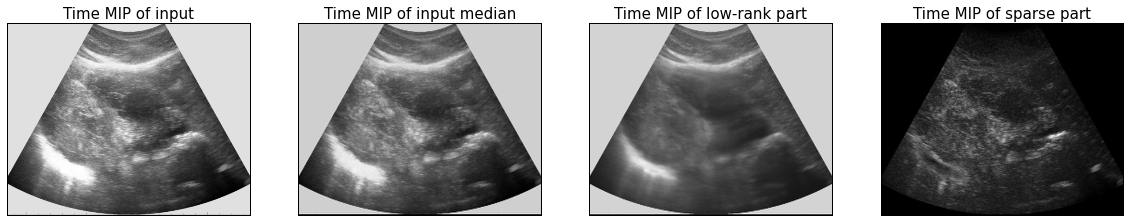

In [49]:
#
# Show MIPs of Input, Lowrank and Sparse parts
#

# Input
plt.figure(figsize=(20,15))

plt.subplot(141)
mplotShowImage(imInput.max(2))
plt.title('Time MIP of input', fontsize=labelsize)

# smoothed input
plt.subplot(142)
mplotShowImage(imD.max(2))
plt.title('Time MIP of input median', fontsize=labelsize)

# Low Rank
plt.subplot(143)
mplotShowImage(imLowRank.max(2))
plt.title('Time MIP of low-rank part', fontsize=labelsize)

# Sparse
plt.subplot(144)
mplotShowImage(imSparse.max(2))
plt.title('Time MIP of sparse part', fontsize=labelsize)

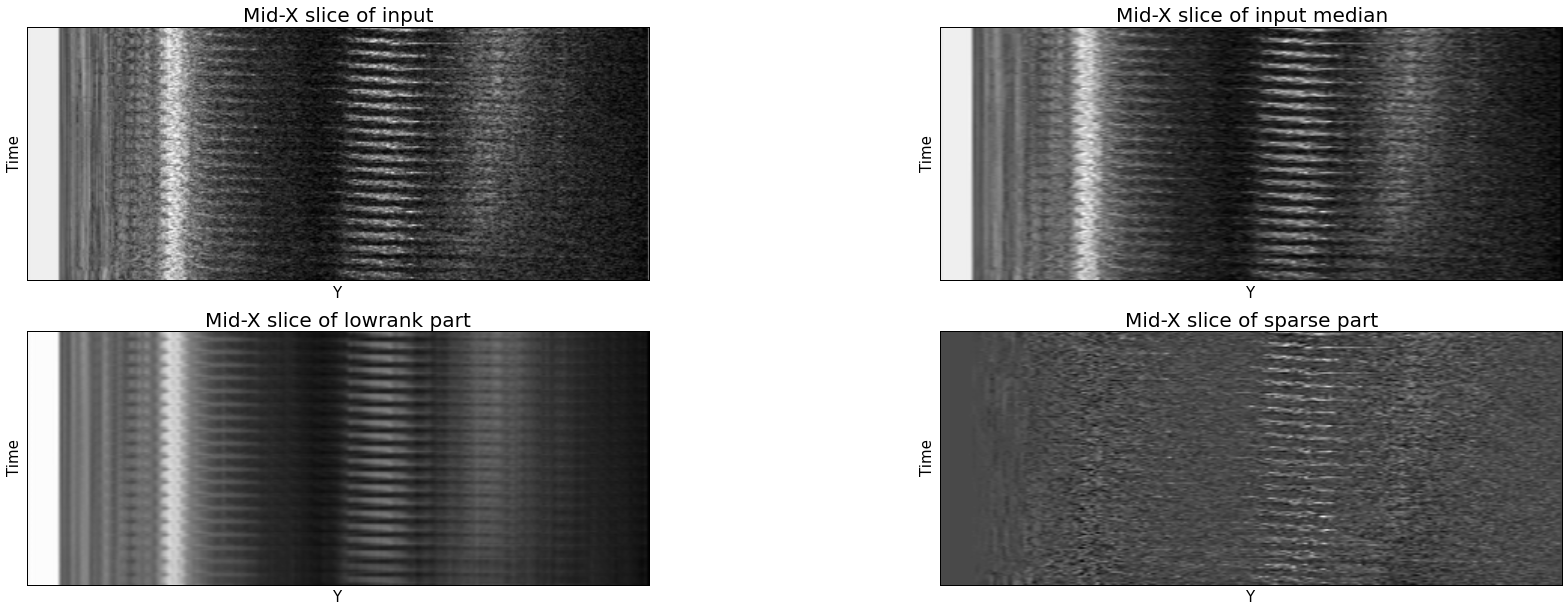

In [52]:
#
# Show Mid XT slices of Input, Lowrank and Sparse parts
#

# Input
plt.figure(figsize=(30, 10))

plt.subplot(221)

mplotShowImage(imInput[:, imInput.shape[1]/2, :].T)
plt.title('Mid-X slice of input', fontsize=titlesize)
plt.ylabel('Time', fontsize=labelsize)
plt.xlabel('Y', fontsize=labelsize)

# Smoothed Input
plt.subplot(222)

mplotShowImage(imD[:, imD.shape[1]/2, :].T)
plt.title('Mid-X slice of input median', fontsize=titlesize)
plt.ylabel('Time', fontsize=labelsize)
plt.xlabel('Y', fontsize=labelsize)

# Low Rank
plt.subplot(223)

mplotShowImage(imLowRank[:, imLowRank.shape[1]/2, :].T)
plt.title('Mid-X slice of lowrank part', fontsize=titlesize)
plt.ylabel('Time', fontsize=labelsize)
plt.xlabel('Y', fontsize=labelsize)

# Sparse
plt.subplot(224)

mplotShowImage(imSparse[:, imSparse.shape[1]/2, :].T)
plt.title('Mid-X slice of sparse part', fontsize=titlesize)
plt.ylabel('Time', fontsize=labelsize)
plt.xlabel('Y', fontsize=labelsize)


In [51]:
# see video
cvShowVideo([normalizeArray(imD), normalizeArray(imLowRank), normalizeArray(imSparse)], 
            ['Input', 'Low-rank', 'Sparse'], 
            resizeAmount=resizeAmount)

In [149]:
# save results to disk
writeVideoToFile(normalizeArray(imD) * 255, 
                 os.path.join(resultsDir, '%s.D.g%.4f.avi' % (resultFilePrefix, gamma)), 
                 codec='DIVX', fps=framesPerSecDownsmp)
writeVideoToFile(normalizeArray(imLowRank) * 255, 
                 os.path.join(resultsDir, '%s.lowrank.g%.4f.avi' % (resultFilePrefix, gamma)), 
                 codec='DIVX', fps=framesPerSecDownsmp)
writeVideoToFile(normalizeArray(imSparse) * 255, 
                 os.path.join(resultsDir, '%s.sparse.g%.4f.avi' % (resultFilePrefix, gamma)), 
                 codec='DIVX', fps=framesPerSecDownsmp)

True
Writing video ./VibratingCircle/VibratingCircle.D.g0.0333.avi took 0.00464582443237 seconds
True
Writing video ./VibratingCircle/VibratingCircle.lowrank.g0.0333.avi took 0.00491380691528 seconds
True
Writing video ./VibratingCircle/VibratingCircle.sparse.g0.0333.avi took 0.00431704521179 seconds


In [ ]:
# save results to disk as tiff stick
writeVideoAsTiffStack(imD, os.path.join(resultsDir, '%s.D' % resultFilePrefix))
writeVideoAsTiffStack(imLowRank, os.path.join(resultsDir, '%s.lowrank' % resultFilePrefix))
writeVideoAsTiffStack(imSparse, os.path.join(resultsDir, '%s.sparse' % resultFilePrefix))

### Display results of phase estimation

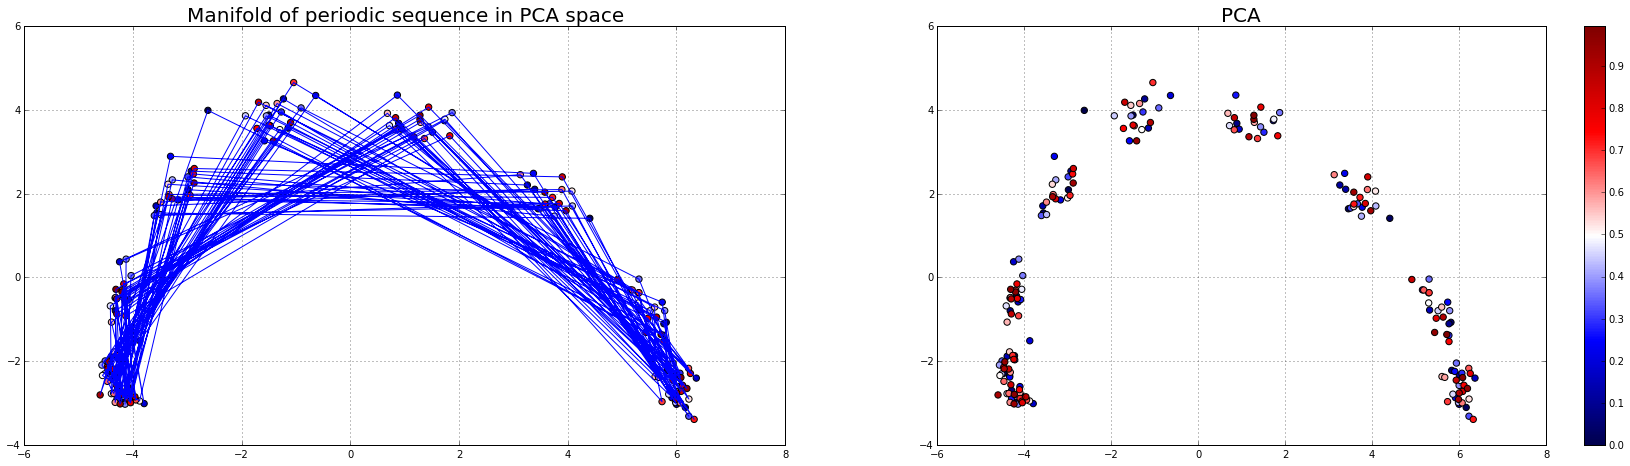

In [19]:
# visualize pca reduced subspace
cmap = plt.cm.seismic
color = np.arange(imInput.shape[2]) / np.float(imInput.shape[2])

fig = plt.figure()

plt.subplot(1, 2, 2)
plt.scatter(X_proj[:, 0], X_proj[:, 1], s=40, c=color, cmap=cmap)
plt.title("PCA", fontsize=titlesize)
plt.colorbar()

plt.subplot(1, 2, 1)
plt.scatter(X_proj[:, 0], X_proj[:, 1], s=40, c=color, cmap=cmap)
t = range(X_proj.shape[0])
t.append(0)
plt.plot(X_proj[t, 0], X_proj[t, 1], '-')
plt.title("Manifold of periodic sequence in PCA space", fontsize=titlesize)       

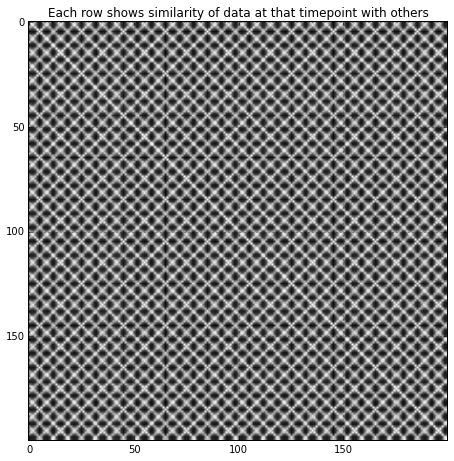

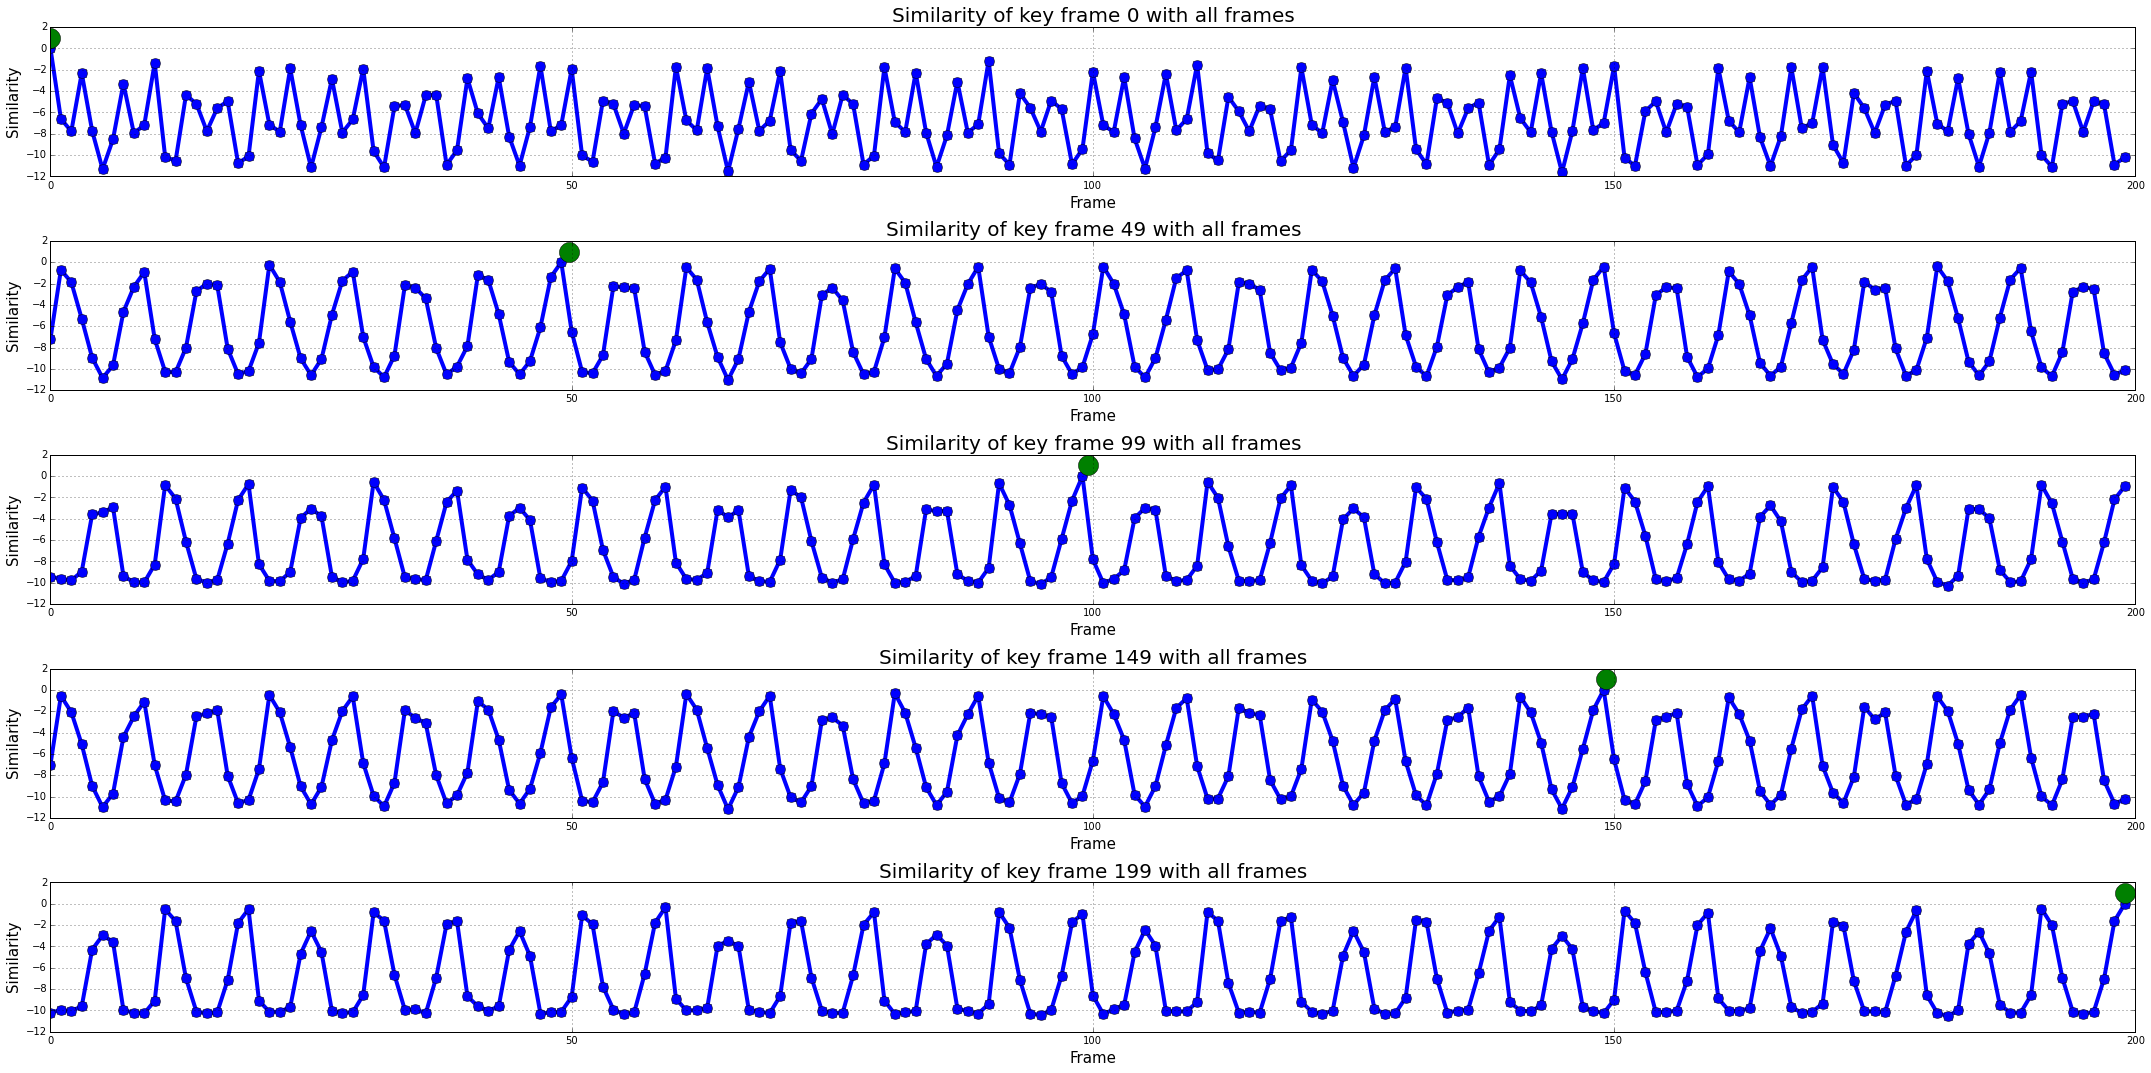

In [21]:
# show the whole similarity landscape       
fig = plt.figure()

plt.imshow(simMat)
plt.title('Each row shows similarity of data at that timepoint with others')

# show similarity landscape of select frames
plt.figure(figsize=(30,15))

keyFrameList = np.linspace(0, imInput.shape[2]-1, 5, endpoint=True)
#keyFrameList = np.arange(0, 10, 2)

for i in range(len(keyFrameList)):
    
    keyFrameId = keyFrameList[i]
    
    plt.subplot(len(keyFrameList), 1, i+1)
    
    plt.plot(simMat[keyFrameId, :], '-o', markersize=10, linewidth=4)
    plt.plot(keyFrameId, 1.0, 'o', markersize=20)
    plt.xlabel('Frame', fontsize=labelsize)
    plt.ylabel('Similarity', fontsize=labelsize)
    #plt.ylim([simFrame.min()-0.01, 1.0])     
    plt.xlim([0, simMat.shape[1]])
    plt.title('Similarity of key frame %d with all frames' % keyFrameId, fontsize=titlesize)   
    
plt.tight_layout()    

beats per minute at 6.666667 fps = 60.000000


/home/cdeepakroy/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


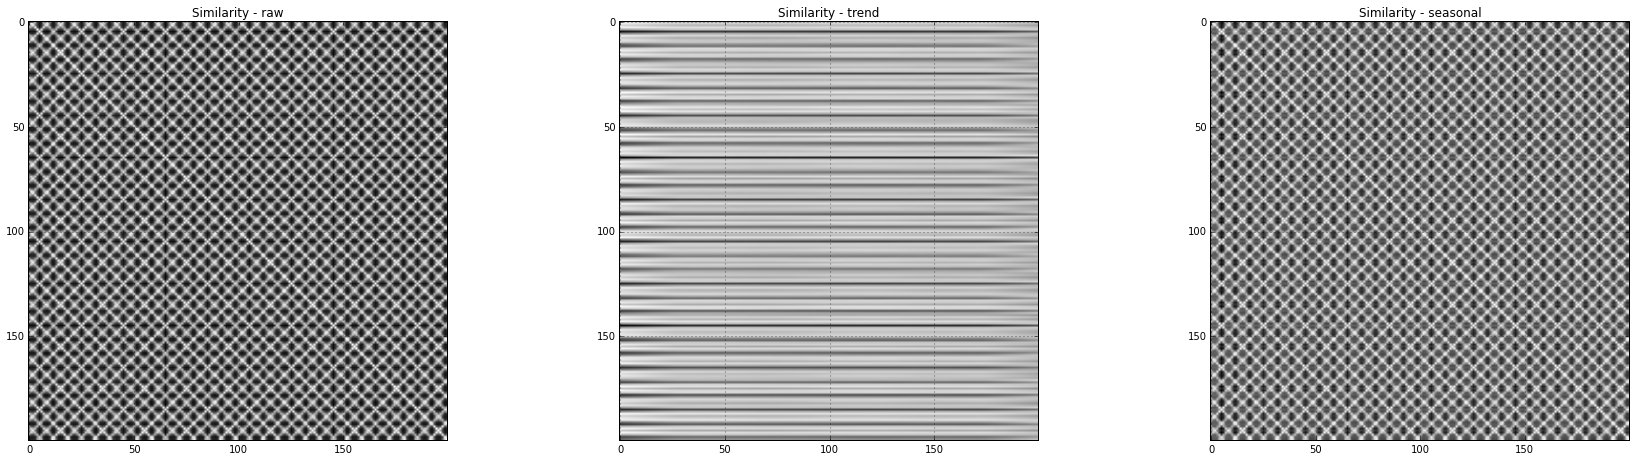

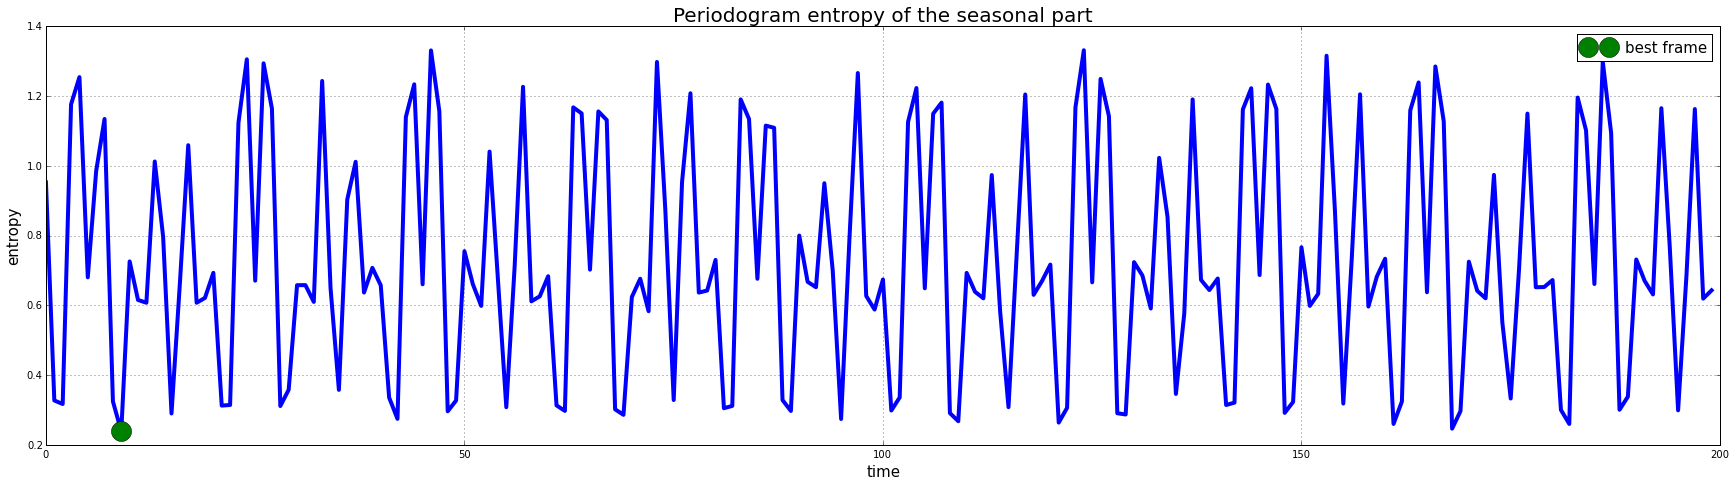

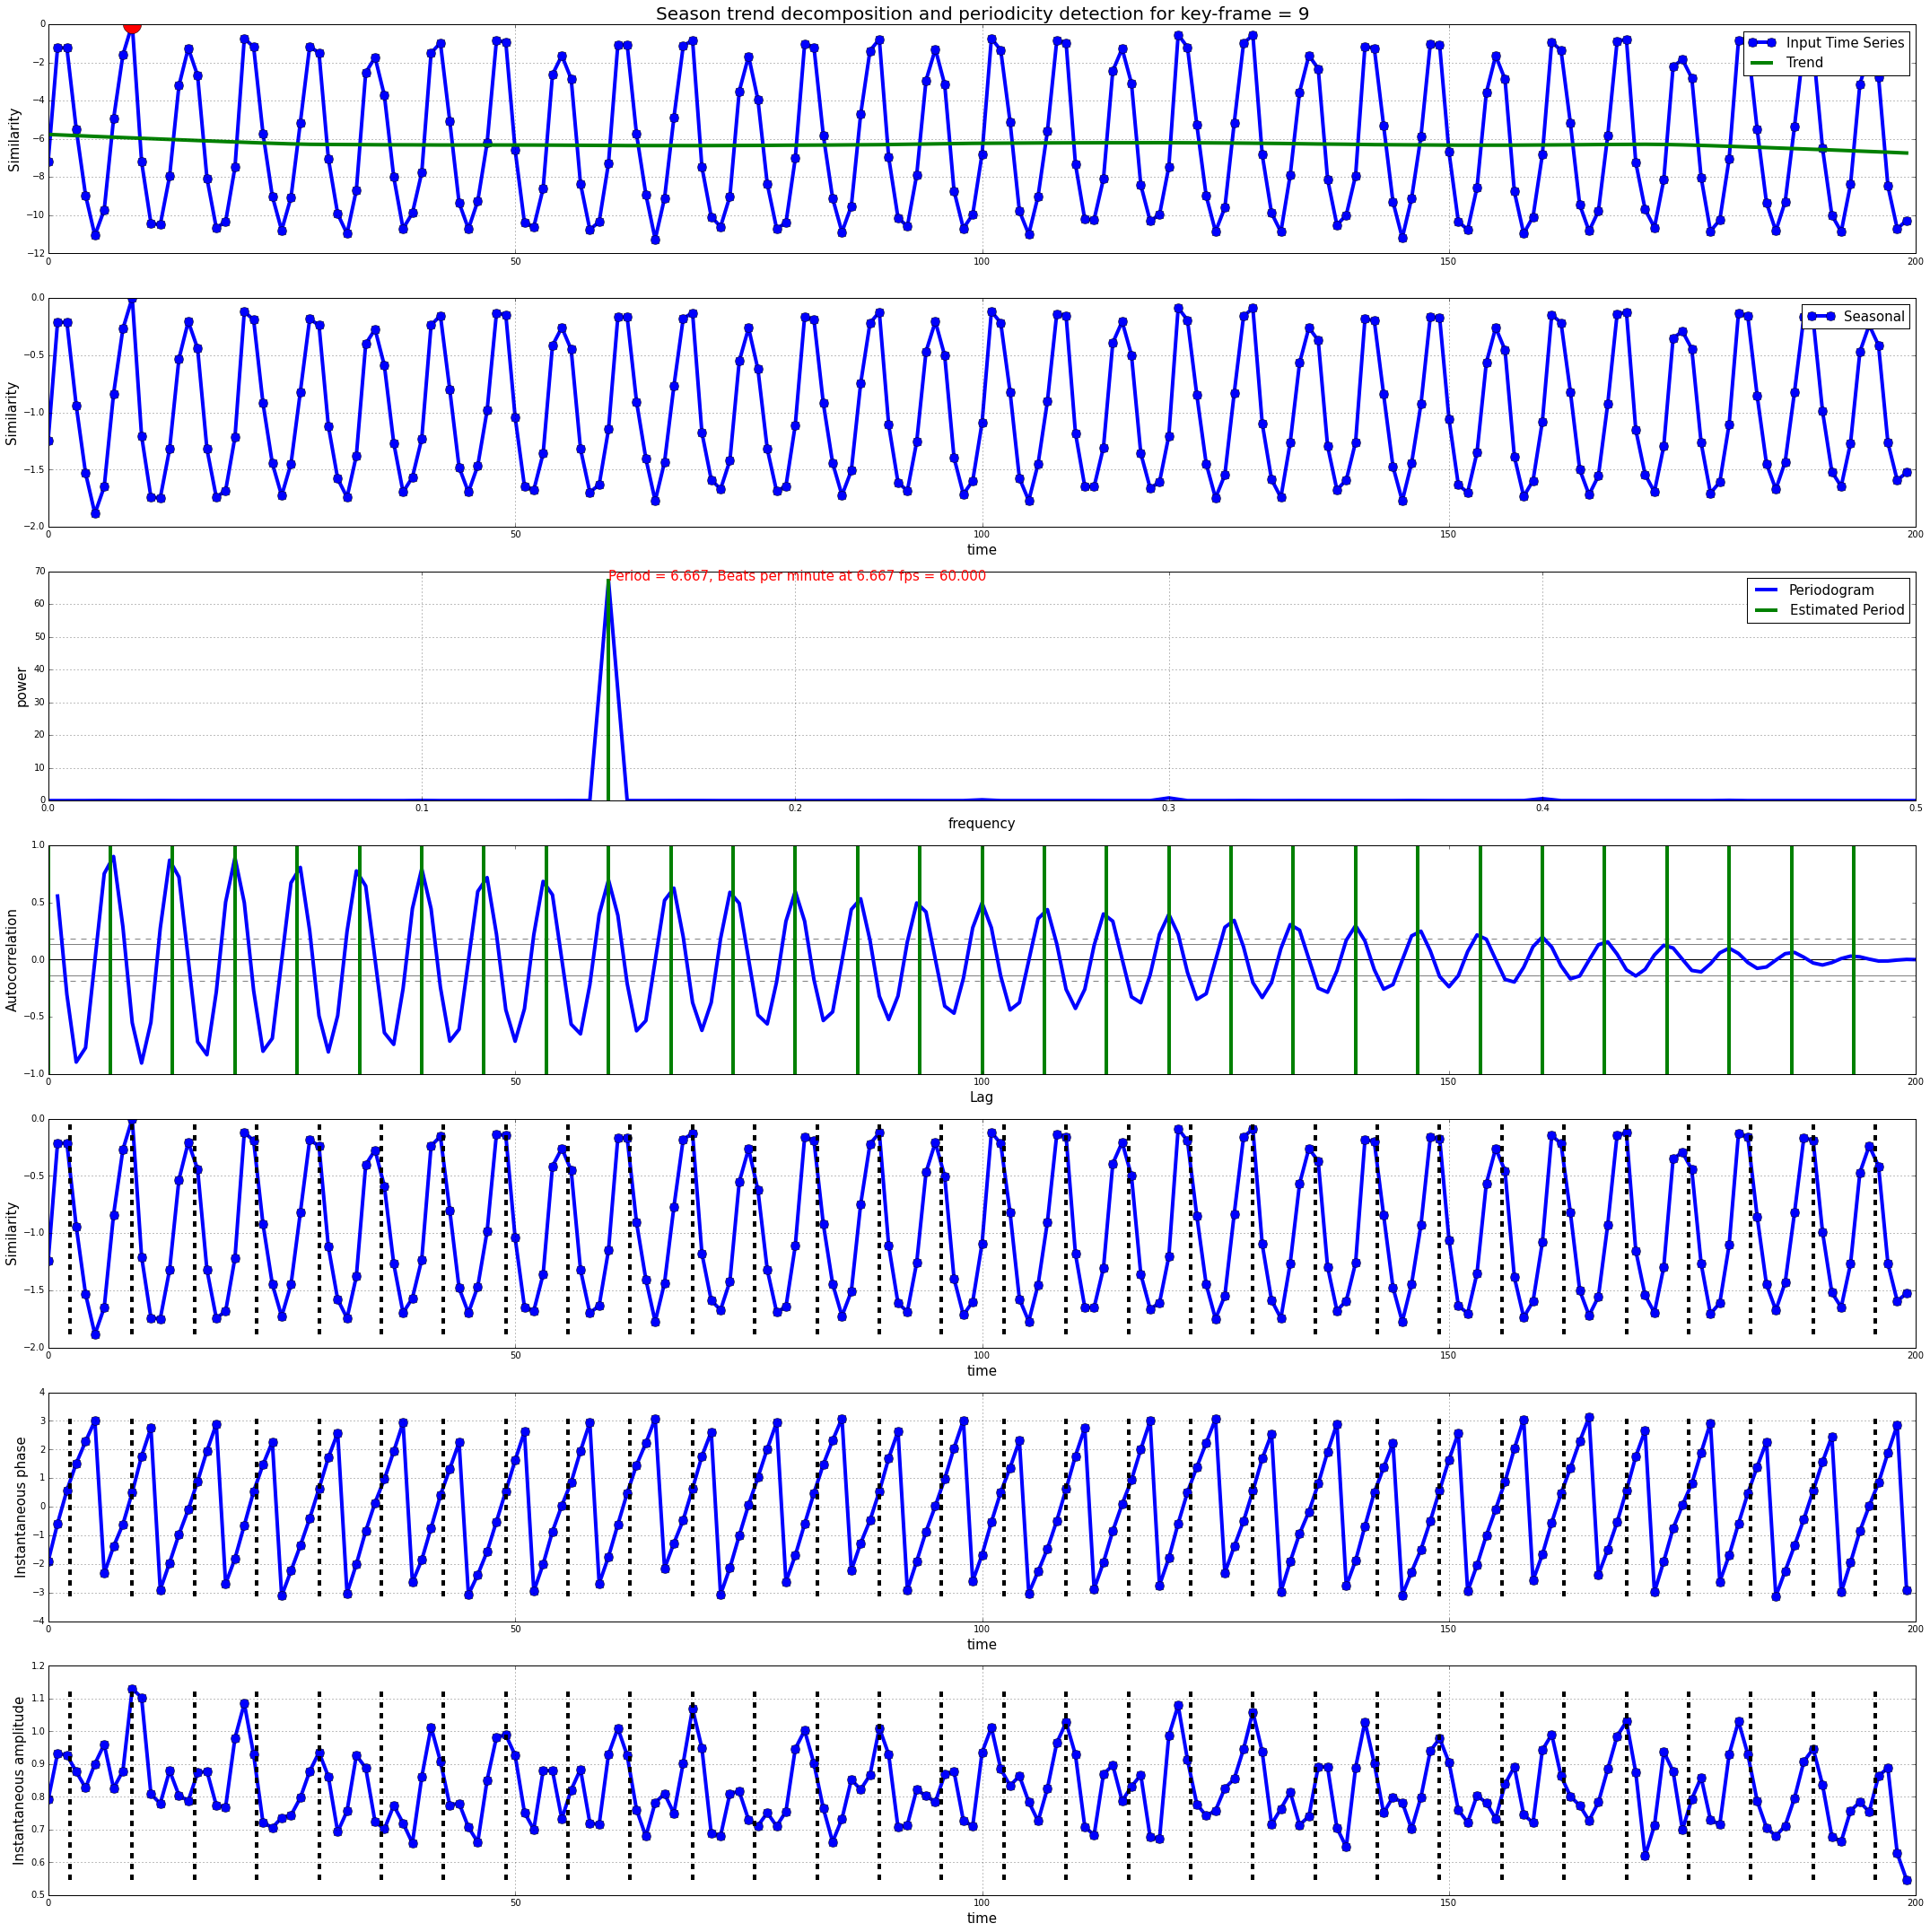

In [23]:
#
# plot the whole similarity landscape along with its trend and seasonal parts
#
fig, ax = plt.subplots(1, 3)

ax[0].imshow(simMat)
ax[0].set_title('Similarity - raw')

ax[1].imshow(simMat_Trend)
ax[1].set_title('Similarity - trend')

ax[2].imshow(simMat_Seasonal)
ax[2].set_title('Similarity - seasonal')

#
# Plot frame entropy
#
plt.figure()
plt.plot(spectralEntropy, linewidth=4)
plt.plot(fid_best, spectralEntropy[fid_best], 'o', markersize=20, label='best frame')
plt.xlabel('time', fontsize=labelsize)
plt.ylabel('entropy', fontsize=labelsize)
plt.title('Periodogram entropy of the seasonal part', fontsize=titlesize)
plt.legend(fontsize=labelsize)

#
# Plot time series decomposition
#
fig, ax = plt.subplots(7, 1, figsize=(30, 30))
ax[0].set_title('Season trend decomposition and periodicity detection for key-frame = %d' % fid_best, 
                fontsize=titlesize)

ax[0].plot(ts, '-o', markersize = 10, linewidth=4, label='Input Time Series')
ax[0].plot(ts_trend, linewidth=4, label='Trend')
ax[0].plot(fid_best, ts[fid_best], 'o', markersize=20)
ax[0].legend(fontsize=labelsize)
ax[0].set_ylabel('Similarity', fontsize=labelsize)

ax[1].plot(ts_seasonal, '-o', markersize = 10, linewidth=4, label='Seasonal')
ax[1].set_xlabel('time', fontsize=labelsize)
ax[1].set_ylabel('Similarity', fontsize=labelsize)
ax[1].legend(fontsize=labelsize)

#
# Plot periodogram and estimated period
#
# show period on periodogram
freq, power = scipy.signal.periodogram(ts_seasonal)
beatsPerMinute = algo.period_ * 60.0 / framesPerSecDownsmp
print "beats per minute at %f fps = %f" % (framesPerSecDownsmp, beatsPerMinute)
maxPowerLoc = np.argmax(power)

ax[2].plot(freq, power, linewidth=4, label='Periodogram')
ax[2].plot([freq[maxPowerLoc], freq[maxPowerLoc]], 
           [0, power[maxPowerLoc]], 'g', linewidth=4, label='Estimated Period')
ax[2].text(freq[maxPowerLoc], power[maxPowerLoc], 
           'Period = %.3f, Beats per minute at %.3f fps = %.3f' % (period, framesPerSecDownsmp, beatsPerMinute), 
            fontsize=labelsize, color='r')
ax[2].set_xlabel('frequency', fontsize=labelsize)
ax[2].set_ylabel('power', fontsize=labelsize)
ax[2].legend(fontsize=labelsize)

# show period on the autocorrelation plot
pdplot.autocorrelation_plot(ts_seasonal, ax = ax[3], linewidth=4)
#sm.graphics.tsa.plot_acf(ts_seasonal, ax = ax[1], linewidth=4, fft=True, use_vlines=False, linestyle='-')
xvals = np.arange(0, ts_seasonal.size, period)
for x in xvals:
    ax[3].plot([x, x], [-1, 1], 'g', linewidth=4)
ax[3].yaxis.label.set_size(labelsize)
ax[3].xaxis.label.set_size(labelsize)

# show period on seasonal part and its instaneous phase
ax[4].plot(ts_seasonal, '-o', markersize = 10, linewidth=4)
ax[4].legend(fontsize=labelsize)
ax[4].set_xlabel('time', fontsize=labelsize)
ax[4].set_ylabel('Similarity', fontsize=labelsize)

ax[5].plot(ts_instaphase, '-o', markersize = 10, linewidth=4)
ax[5].set_xlabel('time', fontsize=labelsize)
ax[5].set_ylabel('Instantaneous phase', fontsize=labelsize)

ax[6].plot(ts_instaamp, '-o', markersize = 10, linewidth=4)
ax[6].set_xlabel('time', fontsize=labelsize)
ax[6].set_ylabel('Instantaneous amplitude', fontsize=labelsize)

seaspeakloc = np.argmax(ts_seasonal)
xvals = np.hstack( (np.arange(seaspeakloc, 0, -period), np.arange(seaspeakloc, ts_seasonal.size, period)) )
for x in xvals:    
    ax[4].plot([x, x], [ts_seasonal.min(), ts_seasonal.max()], '--k', linewidth=4)
    ax[5].plot([x, x], [ts_instaphase.min(), ts_instaphase.max()], '--k', linewidth=4)
    ax[6].plot([x, x], [ts_instaamp.min(), ts_instaamp.max()], '--k', linewidth=4)

fig.tight_layout()

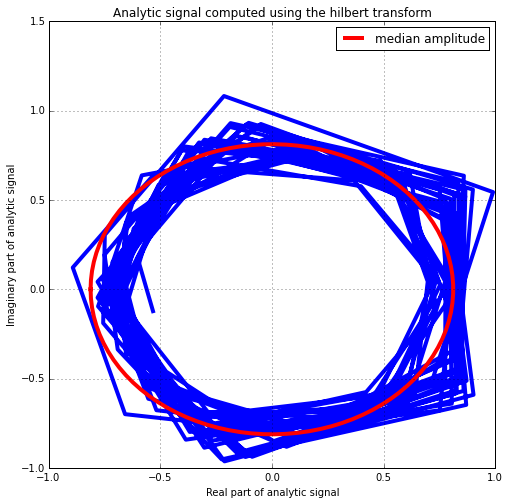

In [24]:
# show analytic signal
plt.figure(figsize=(8,8))
plt.plot(np.real(ts_analytic), np.imag(ts_analytic), linewidth=4)

xvals = np.linspace(-np.pi, np.pi, 100)
medianAmp = np.median(np.abs(ts_analytic))
plt.plot(medianAmp * np.cos(xvals), medianAmp * np.sin(xvals), 'r-', 
         linewidth=4, label='median amplitude')

plt.title('Analytic signal computed using the hilbert transform')
plt.xlabel('Real part of analytic signal')
plt.ylabel('Imaginary part of analytic signal')
plt.legend()

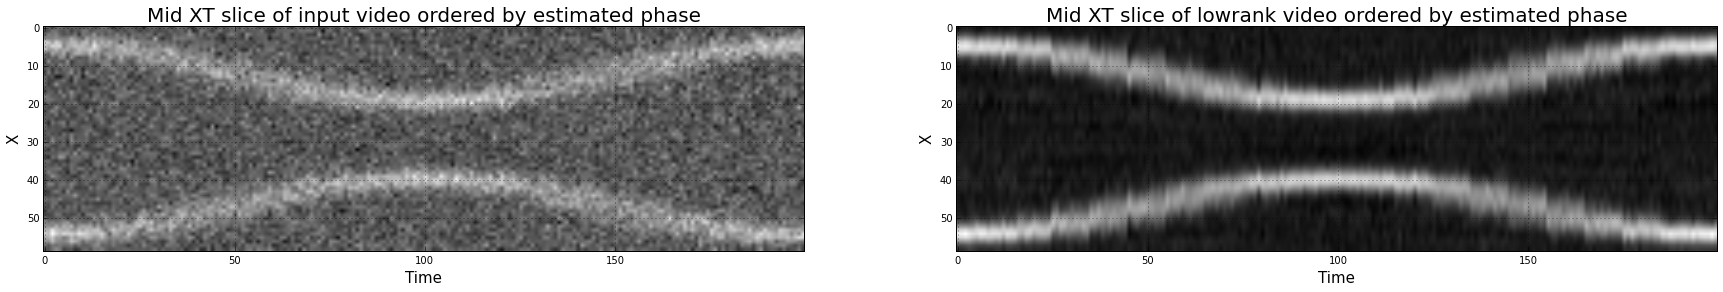

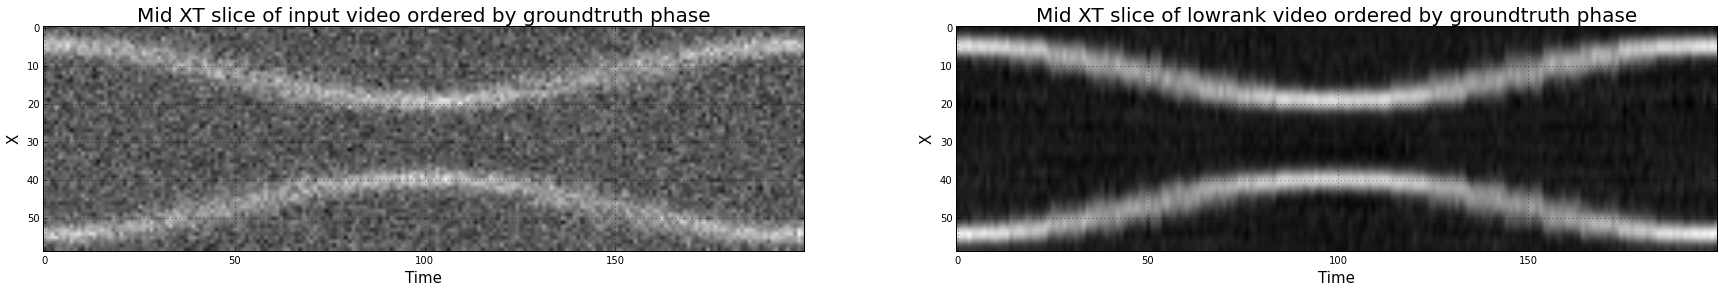

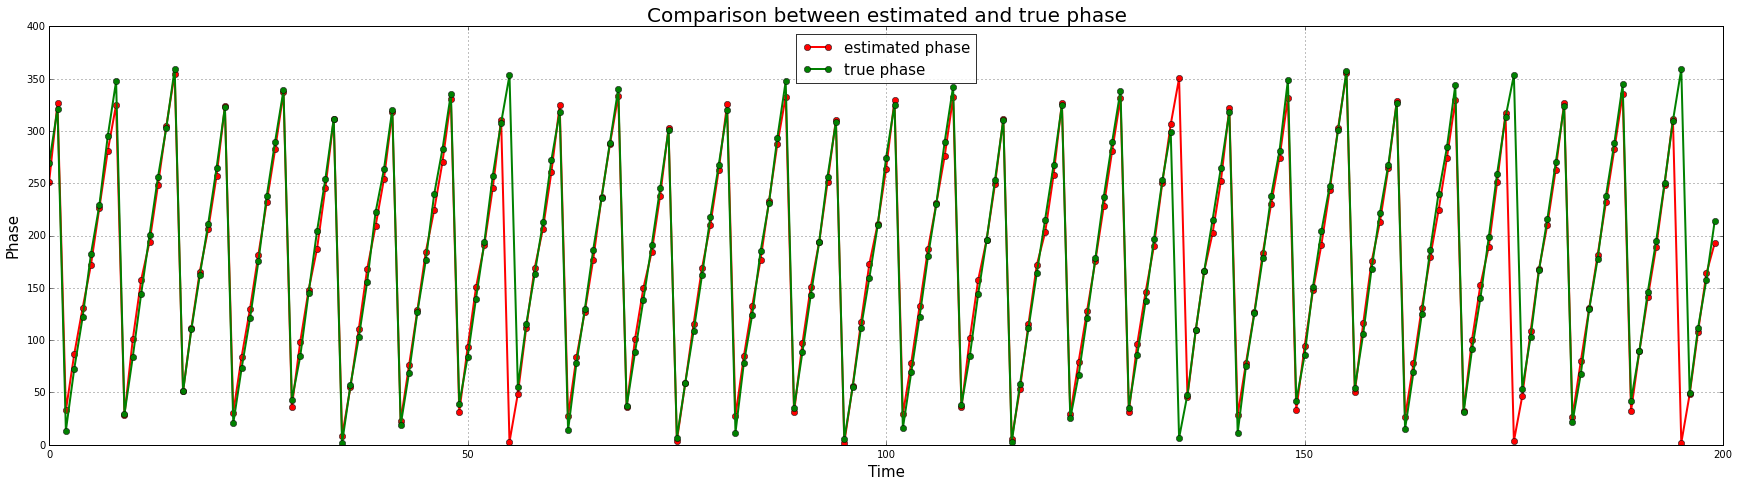

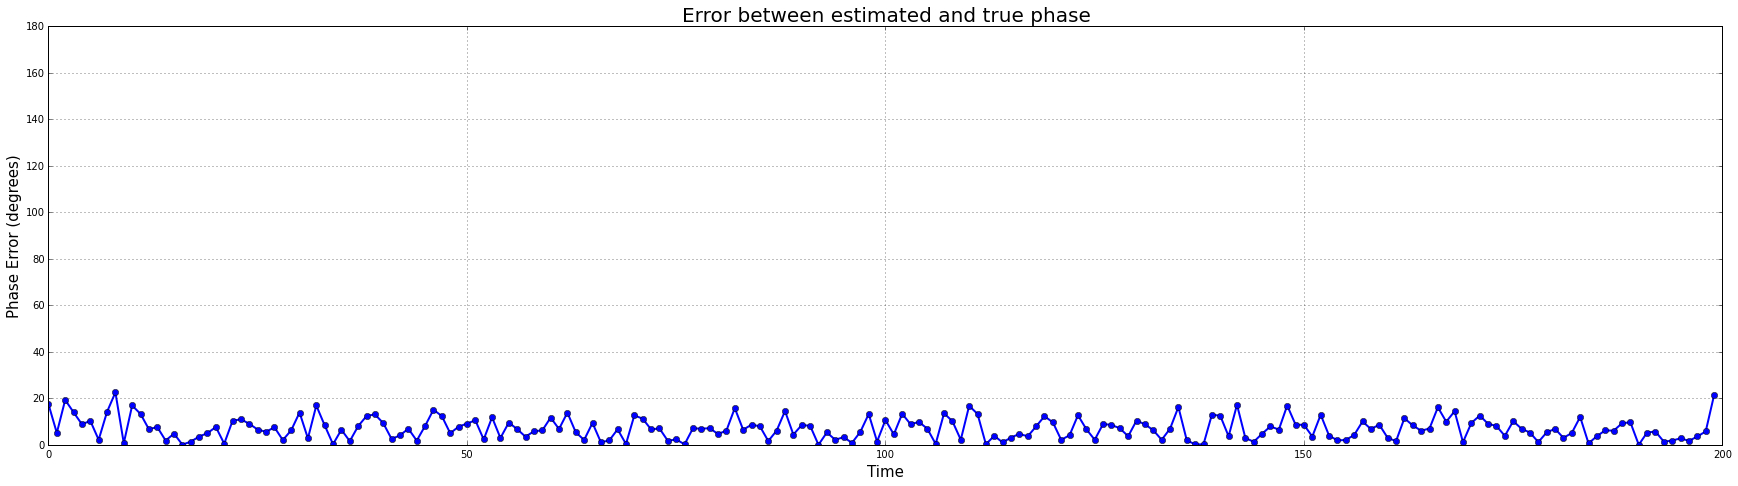

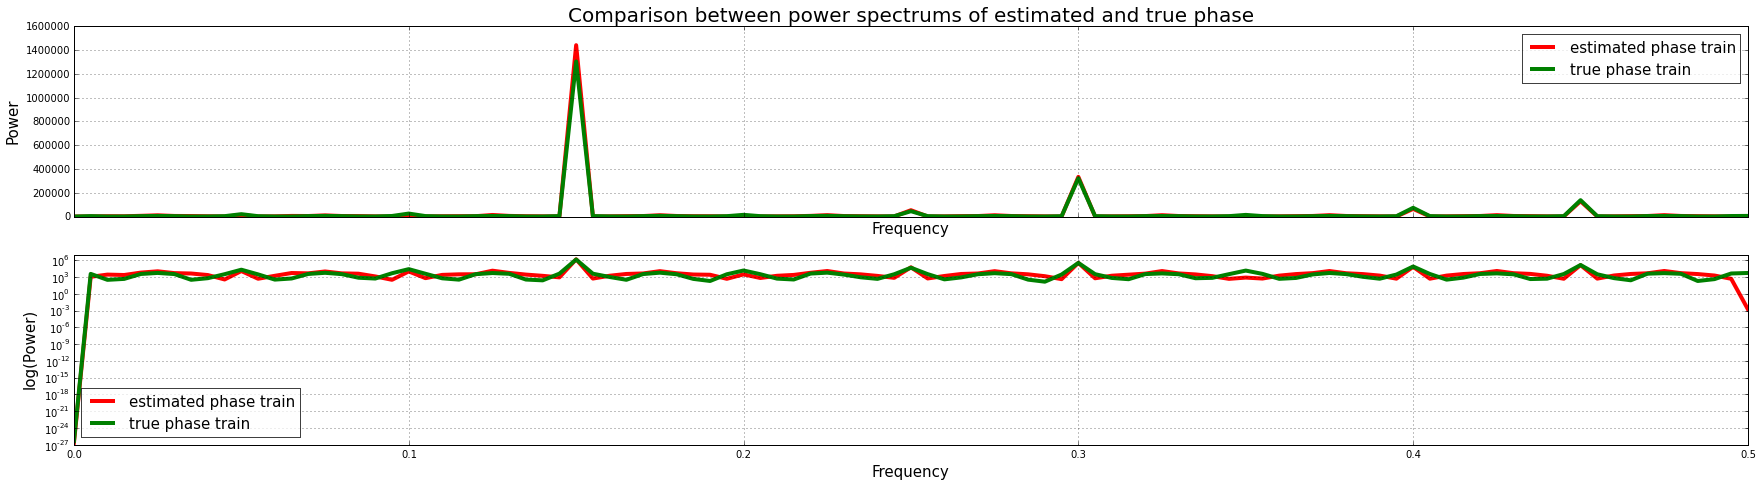

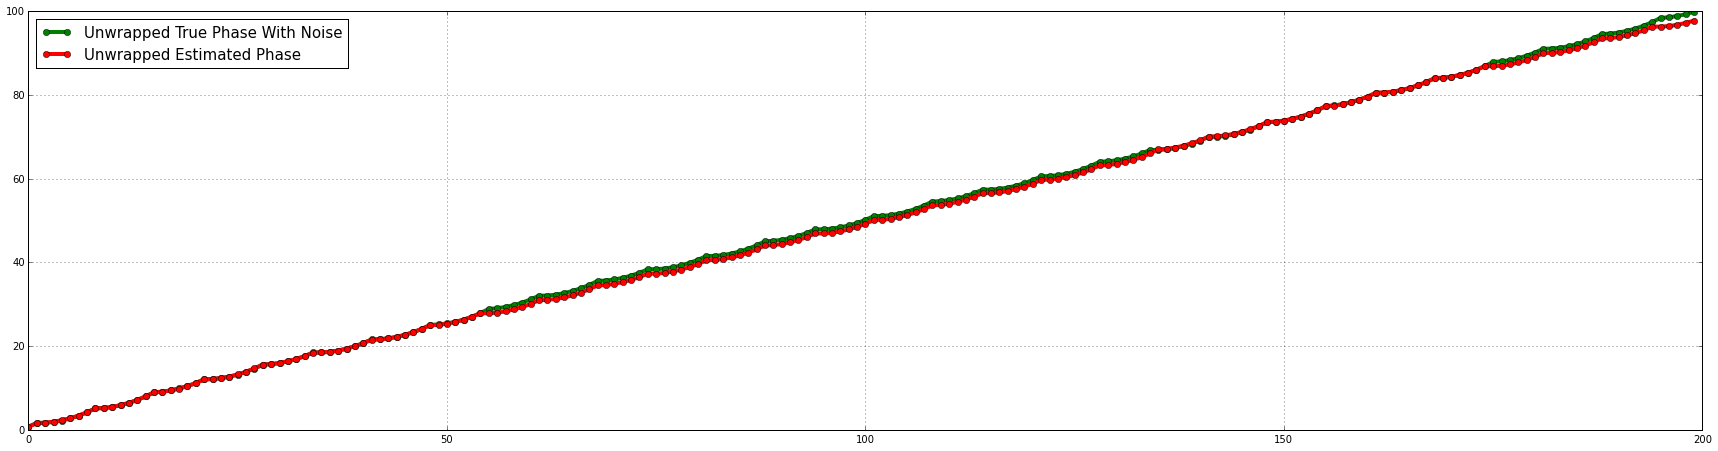

In [28]:
# order frames by phase
phaseord_est = np.argsort( ts_instaphase )
imInput_phaseord_est = imInput[:,:,phaseord_est]
imLowrank_phaseord_est = imLowRank[:,:,phaseord_est]

# show mid xz slice
plt.figure(figsize=(30, 10))

plt.subplot(121)
plt.imshow(imInput_phaseord_est[:, imInput_phaseord_est.shape[1]/2, :])
plt.title('Mid XT slice of input video ordered by estimated phase', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('X', fontsize=labelsize)

plt.subplot(122)
plt.imshow(imLowrank_phaseord_est[:, imLowrank_phaseord_est.shape[1]/2, :])
plt.title('Mid XT slice of lowrank video ordered by estimated phase', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('X', fontsize=labelsize)

if 'phaseGroundtruth' in locals() and phaseGroundtruth.size > 0:
    
    # order frames by groundtruth phase
    phaseGroundtruthDownsmp = phaseGroundtruth[::timeDownsamplingFrameStep]

    phaseError = normalizeAngles(np.rad2deg(ts_instaphase) - phaseGroundtruthDownsmp, [-180, 180])
    
    #phaseError = normalizeAngles(phaseError - phaseError[fid_best], [-180, 180])
    phaseError = normalizeAngles(phaseError - np.median(phaseError), [-180, 180])
    
    #phaseOffset = (np.rad2deg(ts_instaphase)[fid_best] - phaseGroundtruthDownsmp[fid_best]) % 360     
    phaseOffset = np.median((np.rad2deg(ts_instaphase) - phaseGroundtruthDownsmp) % 360)     
    
    phaseord_gtruth = np.argsort( (phaseGroundtruthDownsmp - phaseOffset) % 360 )
    imInput_phaseord_gtruth = imInput[:,:,phaseord_gtruth]
    imLowrank_phaseord_gtruth = imLowRank[:,:,phaseord_gtruth]

    # show mid xz slice
    plt.figure(figsize=(30, 10))

    plt.subplot(121)
    plt.imshow(imInput_phaseord_gtruth[:, imInput_phaseord_gtruth.shape[1]/2, :])
    plt.title('Mid XT slice of input video ordered by groundtruth phase', fontsize=titlesize)
    plt.xlabel('Time', fontsize=labelsize)
    plt.ylabel('X', fontsize=labelsize)

    plt.subplot(122)
    plt.imshow(imLowrank_phaseord_gtruth[:, imLowrank_phaseord_gtruth.shape[1]/2, :])
    plt.title('Mid XT slice of lowrank video ordered by groundtruth phase', fontsize=titlesize)
    plt.xlabel('Time', fontsize=labelsize)
    plt.ylabel('X', fontsize=labelsize)
    
    # phase train
    plt.figure()
    
    plt.plot(((np.rad2deg(ts_instaphase)) % 360), 'ro-', linewidth=2, label='estimated phase')
    plt.plot(((phaseGroundtruthDownsmp + phaseOffset) % 360), 'go-', linewidth=2, label='true phase') 
    
    plt.xlabel('Time', fontsize=labelsize)
    plt.ylabel('Phase', fontsize=labelsize)
    plt.legend(fontsize=labelsize, framealpha=0.8, loc='best')  
    plt.title('Comparison between estimated and true phase', fontsize=titlesize)

    # phase train error at each time point
    plt.figure()
    
    plt.plot(np.abs(phaseError), '-o', linewidth=2)
    plt.ylim([0, 180])
    plt.xlabel('Time', fontsize=labelsize)
    plt.ylabel('Phase Error (degrees)', fontsize=labelsize)
    plt.legend(fontsize=labelsize, framealpha=0.8, loc='best')  
    plt.title('Error between estimated and true phase', fontsize=titlesize)
    
    # powerspectrun of phase train
    fig, ax = plt.subplots(2, 1, sharex=True)
    
    freq_est, power_est = scipy.signal.periodogram(np.rad2deg(ts_instaphase))
    freq_true, power_true = scipy.signal.periodogram(phaseGroundtruthDownsmp)
    
    ax[0].plot(freq_est, power_est, 'r-', label = 'estimated phase train', linewidth=linewidth)
    ax[0].plot(freq_true, power_true, 'g-', label = 'true phase train', linewidth=linewidth)
    ax[0].set_xlabel('Frequency', fontsize=labelsize)
    ax[0].set_ylabel('Power', fontsize=labelsize)
    ax[0].set_title('Comparison between power spectrums of estimated and true phase', fontsize=titlesize)
    ax[0].legend(fontsize=labelsize, framealpha=0.75, loc='best')    
    
    ax[1].semilogy(freq, power_est, 'r-', label = 'estimated phase train', linewidth=linewidth)
    ax[1].semilogy(freq, power_true, 'g-', label = 'true phase train', linewidth=linewidth)
    ax[1].set_xlabel('Frequency', fontsize=labelsize)
    ax[1].set_ylabel('log(Power)', fontsize=labelsize)
    ax[1].legend(fontsize=labelsize, framealpha=0.75, loc='best')    

    # compare unwrapped phases
    plt.figure()
    
    unwrapped_TruePhase_withnoise = (((phaseGroundtruthDownsmp + phaseOffset) % 360) / 360)
    unwrapped_EstimatedPhase = ((np.rad2deg(ts_instaphase) % 360) / 360)
    
    plt.plot( np.cumsum(unwrapped_TruePhase_withnoise), 'g-o', 
             linewidth=linewidth, label='Unwrapped True Phase With Noise')
    plt.plot( np.cumsum(unwrapped_EstimatedPhase), 'r-o', 
             linewidth=linewidth, label='Unwrapped Estimated Phase')    
    plt.legend(fontsize=labelsize, loc='best')

In [157]:
# show video
if 'phaseGroundtruth' in locals() and phaseGroundtruth.size > 0:
    
    cvShowVideo([normalizeArray(imInput_phaseord_est), normalizeArray(imLowrank_phaseord_est), 
                 normalizeArray(imInput_phaseord_gtruth), normalizeArray(imLowrank_phaseord_gtruth)],
                ['Input Video ordered by estimated phase', 'Lowrank Video ordered by estimated phase',
                 'Input Video ordered by true phase', 'Lowrank Video ordered by true phase',], 
                resizeAmount=resizeAmount)
    
else:    
    
    cvShowVideo([normalizeArray(imInput_phaseord_est), normalizeArray(imLowrank_phaseord_est)],
                ['Input Video ordered by phase', 'Lowrank Video ordered by phase'], resizeAmount=resizeAmount)

In [30]:
writeVideoToFile(normalizeArray(imInput_phaseord_est), 
                 os.path.join(resultsDir, '%s.PhaseOrderedInput.avi' % resultFilePrefix), 
                 codec='DIVX', fps=12)

writeVideoToFile(normalizeArray(imLowrank_phaseord_est), 
                 os.path.join(resultsDir, '%s.PhaseOrderedLowrank.avi' % resultFilePrefix), 
                 codec='DIVX', fps=12)

True
Writing video ./VibratingCircle/VibratingCircle.PhaseOrderedInput.avi took 0.00449514389038 seconds
True
Writing video ./VibratingCircle/VibratingCircle.PhaseOrderedLowrank.avi took 0.00340008735657 seconds


## Step-4: Generate high-resolution video of one period using instantaneous phase of seasonal part 

sigmaGKR =  0.0619576742737
07% 15% 23% 30% 38% 46% 53% 61% 69% 76% 84% 92%

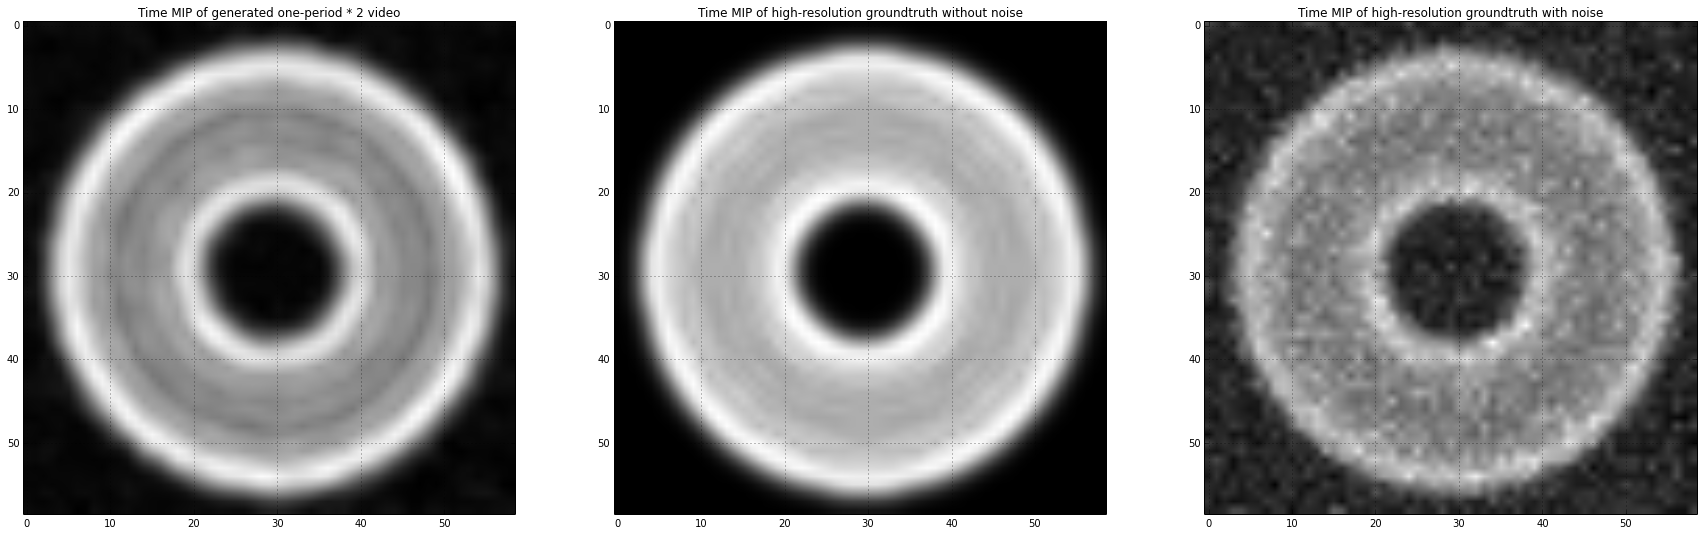

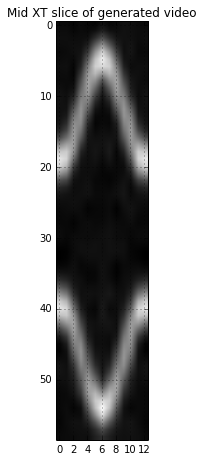

In [166]:
# set upsampling amount
upsamplePerioidFactor = 2 #timeDownsamplingFrameStep
sigmaGKRFactor = 2

# generate video of requested resolution using estimated phase
numOutFrames = np.uint( upsamplePerioidFactor * period + 0.5 )        

imOurOnePeriodMagVideo = algo.generateSinglePeriodVideo(numOutFrames, sigmaGKRFactor=sigmaGKRFactor)

#
# show mips
#

# display MIP of generated video
plt.figure(figsize=(30,20))

plt.subplot(231)
plt.imshow(imOurOnePeriodMagVideo.max(2))
plt.title('Time MIP of generated one-period * %d video' % upsamplePerioidFactor)   

# display MIP of groundtruth
plt.subplot(232)
plt.imshow(imInput_highres_prenoise.max(2))
plt.title('Time MIP of high-resolution groundtruth without noise')        

plt.subplot(233)
plt.imshow(imInput_highres.max(2))
plt.title('Time MIP of high-resolution groundtruth with noise')

# display mid XT slice of generated video
plt.figure()

plt.imshow(imOurOnePeriodMagVideo[:,imOurOnePeriodMagVideo.shape[1]/2,:])
plt.title('Mid XT slice of generated video')   

In [167]:
cvShowVideo([normalizeArray(imInput), normalizeArray(imOurOnePeriodMagVideo)],
            ['Original Video', 'Synthesized One Period Video'], resizeAmount=resizeAmount)

In [160]:
writeVideoToFile(imOurOnePeriodMagVideo, 
                 os.path.join(resultsDir, '%s.OurOnePeriodx%d.avi' % (resultFilePrefix, upsamplePerioidFactor)), 
                 codec='DIVX', fps=12)

True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151322/Heart_20150220_151146.OurOnePeriodx8.avi took 0.723564147949 seconds


# Validation

In [174]:
def ncorr(imA, imB):
    
    imA = (imA - imA.mean()) / imA.std()
    imB = (imB - imB.mean()) / imB.std()
    
    return np.mean(imA * imB)    

## Generate groundtruth by manually cropping a sub-video of one-period length

Look at the instantaneous phase and seasonal part of the frame-to-frame similarity time series and adjust the min/max frame sliders which will then be used to crop out the corresponding part of the video from input high-resolution video

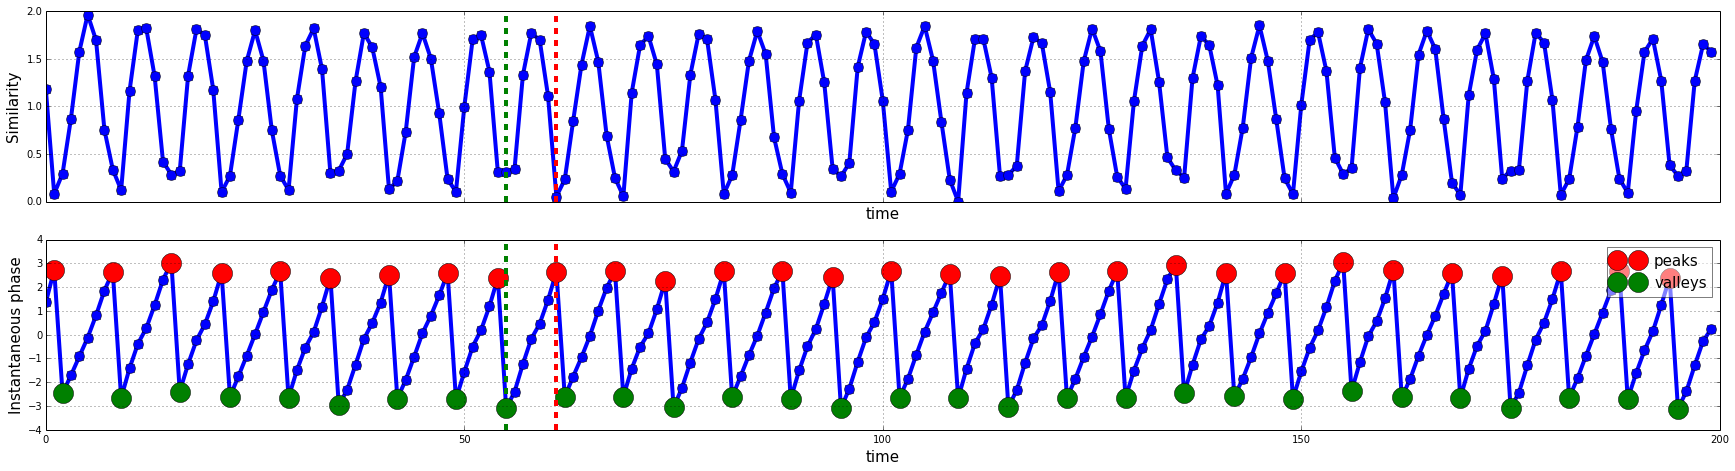

In [168]:
# create min-max frame selector widgets
nf = ts_instaphase.size
minFrameWidget = widgets.IntSliderWidget(min = 0, max = nf, step = 1)
maxFrameWidget = widgets.IntSliderWidget(min = 0, max = nf, step = 1)

# find good initial values for min-max frame
vloc = detect_peaks(ts_instaphase, mph = -np.pi/4, mpd=period * 0.75, valley=True, show=False)
ploc = detect_peaks(ts_instaphase, mph =  np.pi/4, mpd=period * 0.75, valley=False, show=False)

vloc_central = vloc[( (vloc > 0.25 * nf) & (vloc < 0.75 * nf) )]

#vloc_best_ind = np.argmin( np.abs( np.diff( ts_seasonal[vloc_central] ) ) )
vloc_best_ind = np.argmin(ts_instaphase[vloc_central])

minFrameWidget.value = vloc_central[vloc_best_ind]
maxFrameWidget.value = ploc[ploc > minFrameWidget.value + 0.8 * period][0]

# display seasonal part of similarity time series and its instantaneous phase
fig, ax = plt.subplots(2, 1, sharex=True)
plt.close(fig)

ax[0].plot(ts_seasonal, '-o', markersize = 10, linewidth=4)
ax[0].set_xlabel('time', fontsize=labelsize)
ax[0].set_ylabel('Similarity', fontsize=labelsize)
ax[0].legend(fontsize=labelsize, framealpha=0.5)

ax[1].plot(ts_instaphase, '-o', markersize = 10, linewidth=4)
ax[1].set_xlabel('time', fontsize=labelsize)
ax[1].set_ylabel('Instantaneous phase', fontsize=labelsize)
ax[1].plot(ploc, ts_instaphase[ploc], 'ro', markersize = 20, label='peaks')
ax[1].plot(vloc, ts_instaphase[vloc], 'go', markersize = 20, label='valleys')
ax[1].legend(fontsize=labelsize, framealpha=0.5)

# display initial min-max frames
minLine = []
maxLine = []

for aid in range(ax.size):

    minLine.append( ax[aid].plot([minFrameWidget.value, minFrameWidget.value],
                                 ax[aid].get_ylim(), 'g--', linewidth=4)[0] )
    maxLine.append( ax[aid].plot([maxFrameWidget.value, maxFrameWidget.value],
                                 ax[aid].get_ylim(), 'r--', linewidth=4)[0] )

# define and set event handler to show current min-max frames
def show_selected_min_max_frames(minFrame, maxFrame):
    
    # show min-max frames
    for aid in range(ax.size):

        minLine[aid].set_xdata([minFrame, minFrame])
        maxLine[aid].set_xdata([maxFrame, maxFrame])
        
    display(fig)
    
interactive(show_selected_min_max_frames, minFrame = minFrameWidget, maxFrame = maxFrameWidget)

Selected frame range of high-res video: [165, 183]
Image size of single period groundtruth (59, 59, 19)


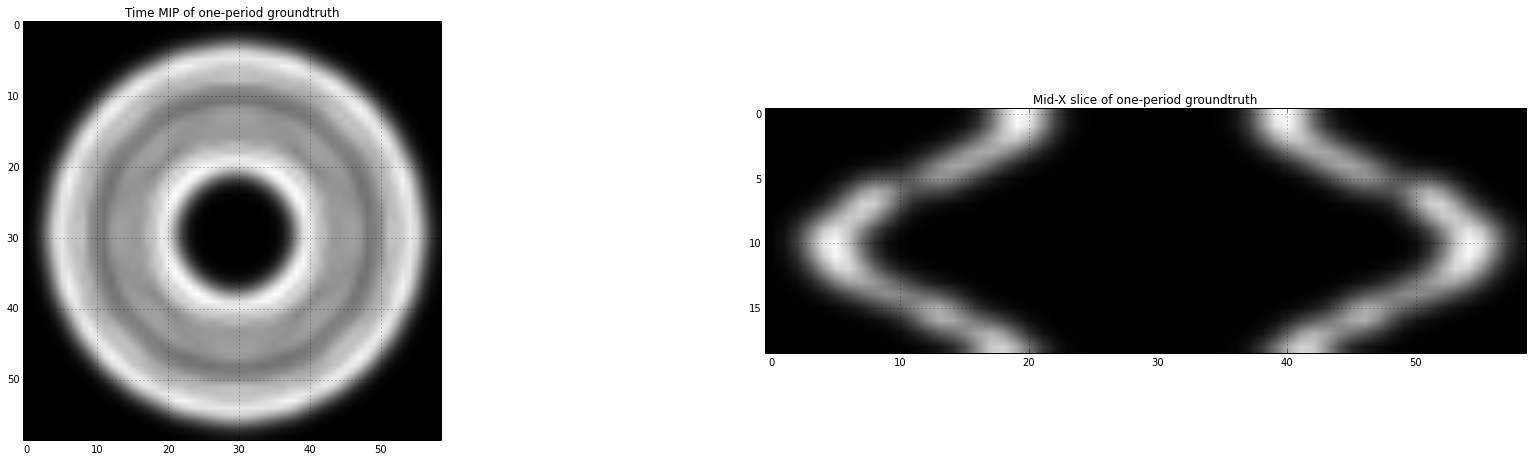

In [169]:
minFrameHighRes = minFrameWidget.value * timeDownsamplingFrameStep
maxFrameHighRes = maxFrameWidget.value * timeDownsamplingFrameStep
print 'Selected frame range of high-res video: [%d, %d]' % (minFrameHighRes, maxFrameHighRes)

imOnePeriod_Groundtruth = imInput_highres_prenoise[:, :, minFrameHighRes:maxFrameHighRes+1]
print 'Image size of single period groundtruth', imOnePeriod_Groundtruth.shape

# display cropped ground truth
fig, ax = plt.subplots(1, 2)

ax[0].imshow(imOnePeriod_Groundtruth.max(2))
ax[0].set_title('Time MIP of one-period groundtruth')    

ax[1].imshow(imOnePeriod_Groundtruth[:, imOnePeriod_Groundtruth.shape[1]/2, :].T)
ax[1].set_title('Mid-X slice of one-period groundtruth')    

In [136]:
cvShowVideo(normalizeArray(imOnePeriod_Groundtruth), 'One-Period Groundtruth', resizeAmount=resizeAmount)

In [227]:
writeVideoToFile(normalizeArray(imOnePeriod_Groundtruth), 
                 os.path.join(resultsDir, '%s.OnePeriod_Groundtruth.avi' % resultFilePrefix), 
                 codec='DIVX', fps=framesPerSec)

True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146/Heart_20150220_151146.OnePeriod_Groundtruth.avi took 0.192201852798 seconds


## Compare the results of our method with spline interpolation

In [170]:
def generateGatedVideoUsingSplineInterp(imInput, numOutFrames, minFrame, maxFrame, splineOrder):
    
    tZoom = np.float(numOutFrames) / (maxFrame - minFrame + 1)

    return scipy.ndimage.interpolation.zoom(imInput[:,:,minFrame:maxFrame+1], (1, 1, tZoom), order=splineOrder)  

In [182]:
numOutFrames = imOnePeriod_Groundtruth.shape[2]

# compute the result using spline interpolation
print '\nValidating the gated video generated using spline interpolation ... ', 

maxSplineOrder = 6

imOnePeriodVal_Spline = [None]*maxSplineOrder
sim_Spline = np.zeros((maxSplineOrder, 1))

for splineOrder in range(maxSplineOrder):
    
    imOnePeriodVal_Spline[splineOrder] = generateGatedVideoUsingSplineInterp(imInput, numOutFrames,
                                                                             minFrameWidget.value, 
                                                                             maxFrameWidget.value,
                                                                             splineOrder)
    
    sim_Spline[splineOrder] = ncorr(imOnePeriod_Groundtruth, imOnePeriodVal_Spline[splineOrder])
    
    # update progress
    print splineOrder,    

# compute result using our method
print '\nValidating the gated video generated using our method ... '

phaseRange = [(i + np.pi) / (2.0 * np.pi) 
              for i in ts_instaphase[ [minFrameWidget.value, maxFrameWidget.value] ] ]

imOnePeriodVal_Our = algo.generateSinglePeriodVideo(imOnePeriod_Groundtruth.shape[2], 
                                                    sigmaGKRFactor=2, phaseRange=phaseRange)  

sim_Our = ncorr(imOnePeriod_Groundtruth, imOnePeriodVal_Our)


Validating the gated video generated using spline interpolation ...  0 1 2 3 4 5 
Validating the gated video generated using our method ... 
sigmaGKR =  0.0619576742737
05% 10% 15% 21% 26% 31% 36% 42% 47% 52% 57% 63% 68% 73% 78% 84% 89% 94%


0 1 2 3 4 5

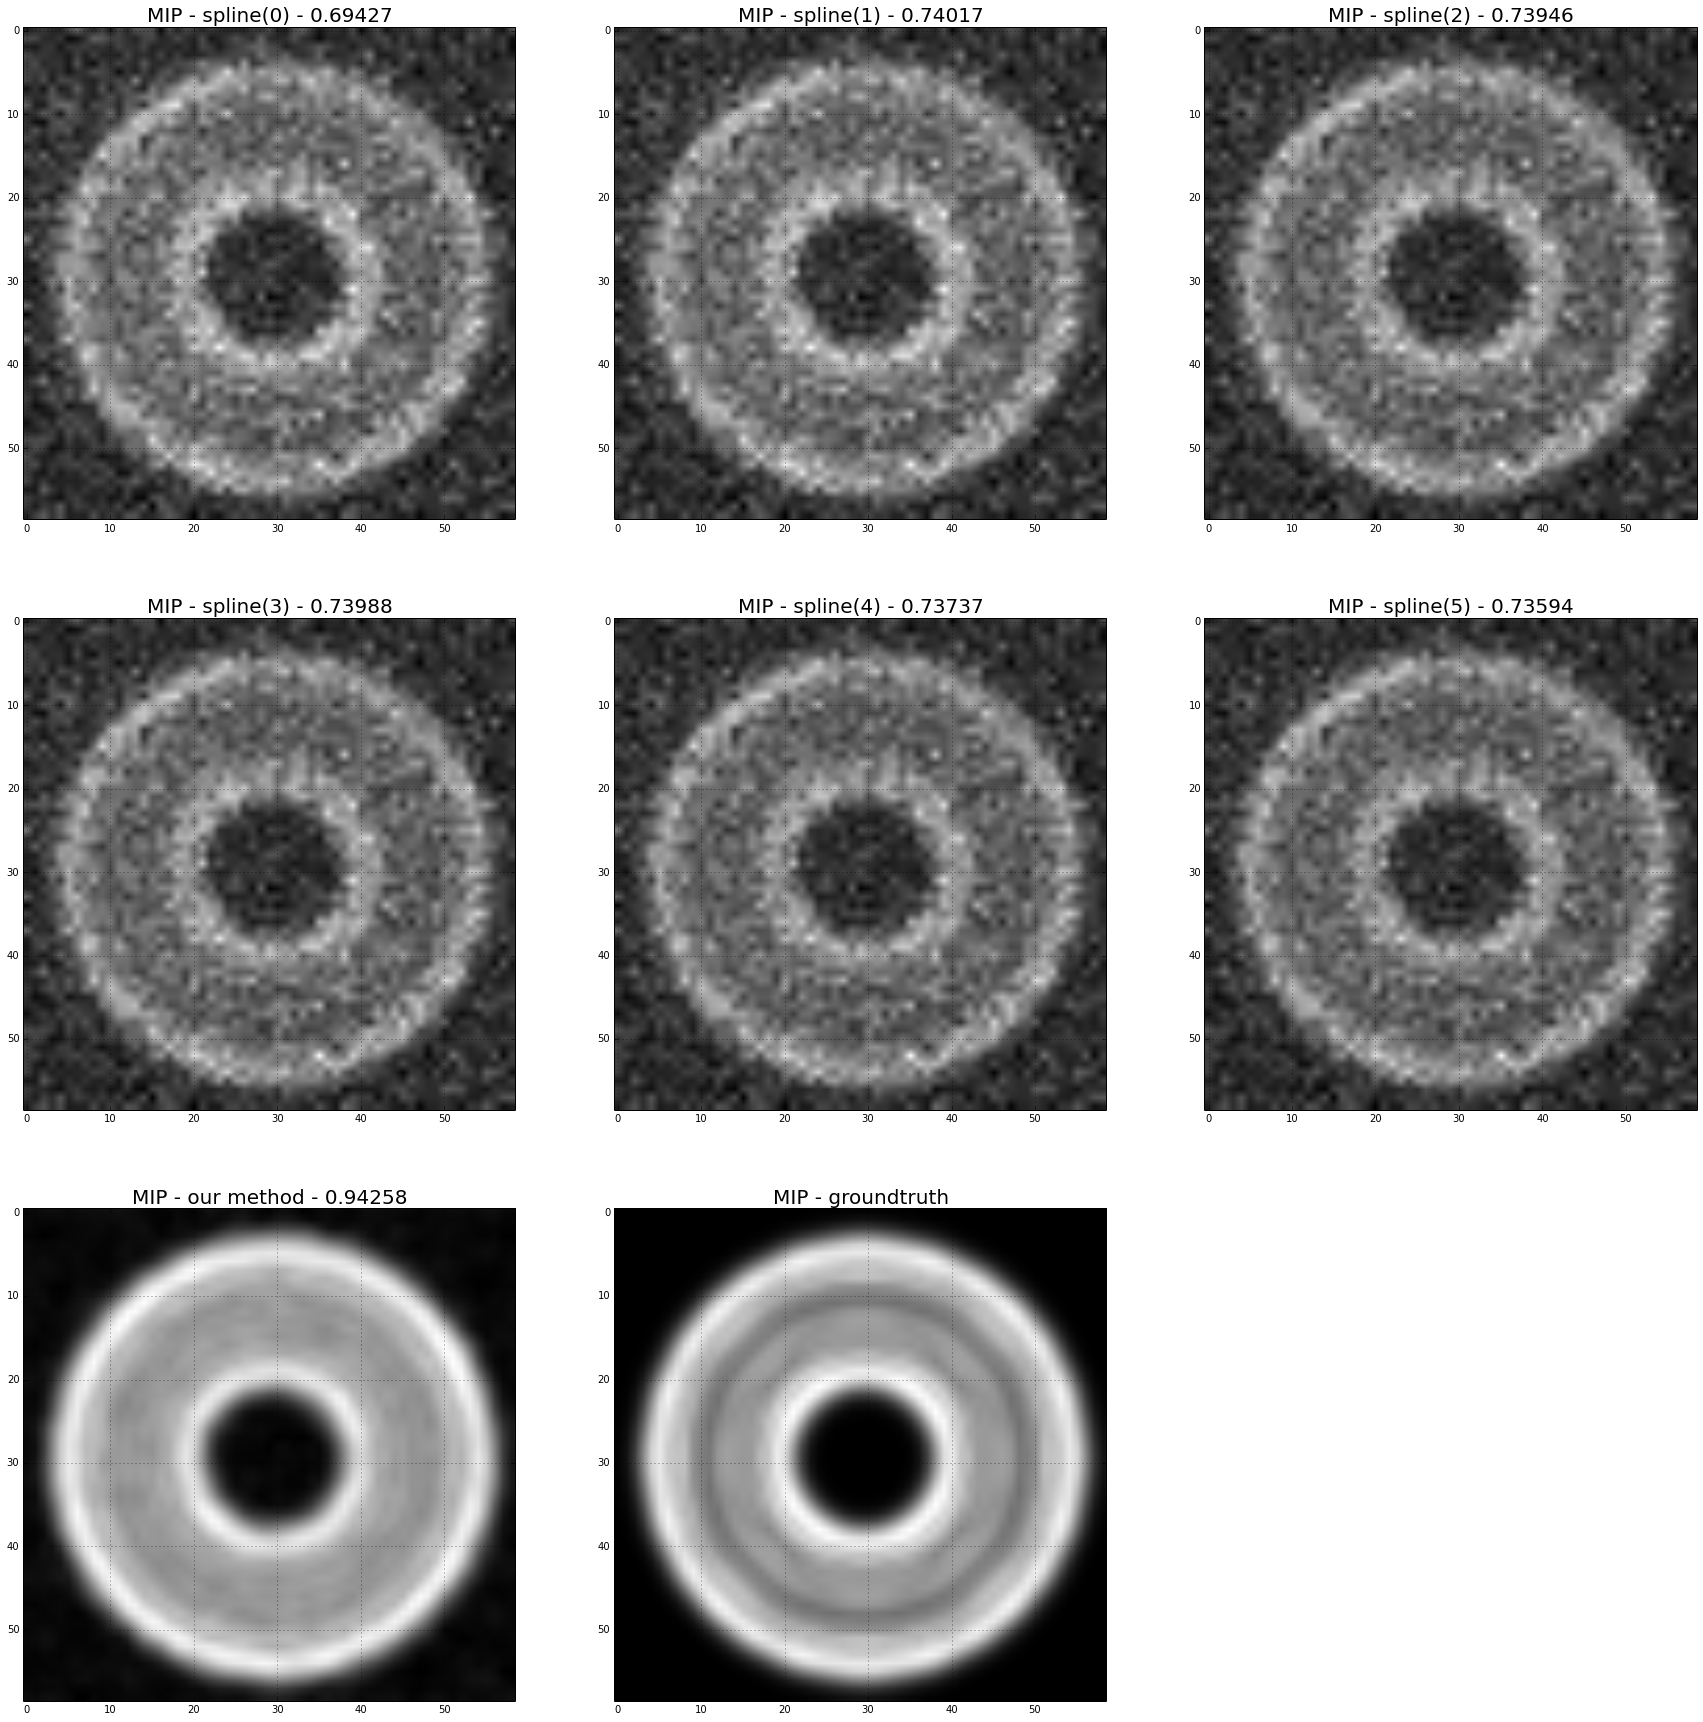

In [183]:
#
# show Time MIPs to check denoising 
#

# show result using spline interpolation
plt.figure(figsize=(30, 30))

for splineOrder in range(maxSplineOrder):
    
    # show MIP
    plt.subplot2grid((3, 3), (splineOrder/3, splineOrder%3))
    imshow(imOnePeriodVal_Spline[splineOrder].max(2))
    plt.title('MIP - spline(%d) - %.5f' % (splineOrder, sim_Spline[splineOrder]), 
              fontsize=titlesize)   

    # update progress
    print splineOrder,    

# show result using our method with RBF
plt.subplot2grid((3, 3), (2, 0))
plt.imshow(imOnePeriodVal_Our.max(2))
plt.title('MIP - our method - %.5f' % sim_Our, fontsize=titlesize)

# show groundtruth
plt.subplot2grid((3, 3), (2, 1))
plt.imshow(imOnePeriod_Groundtruth.max(2))
plt.title('MIP - groundtruth', fontsize=titlesize)

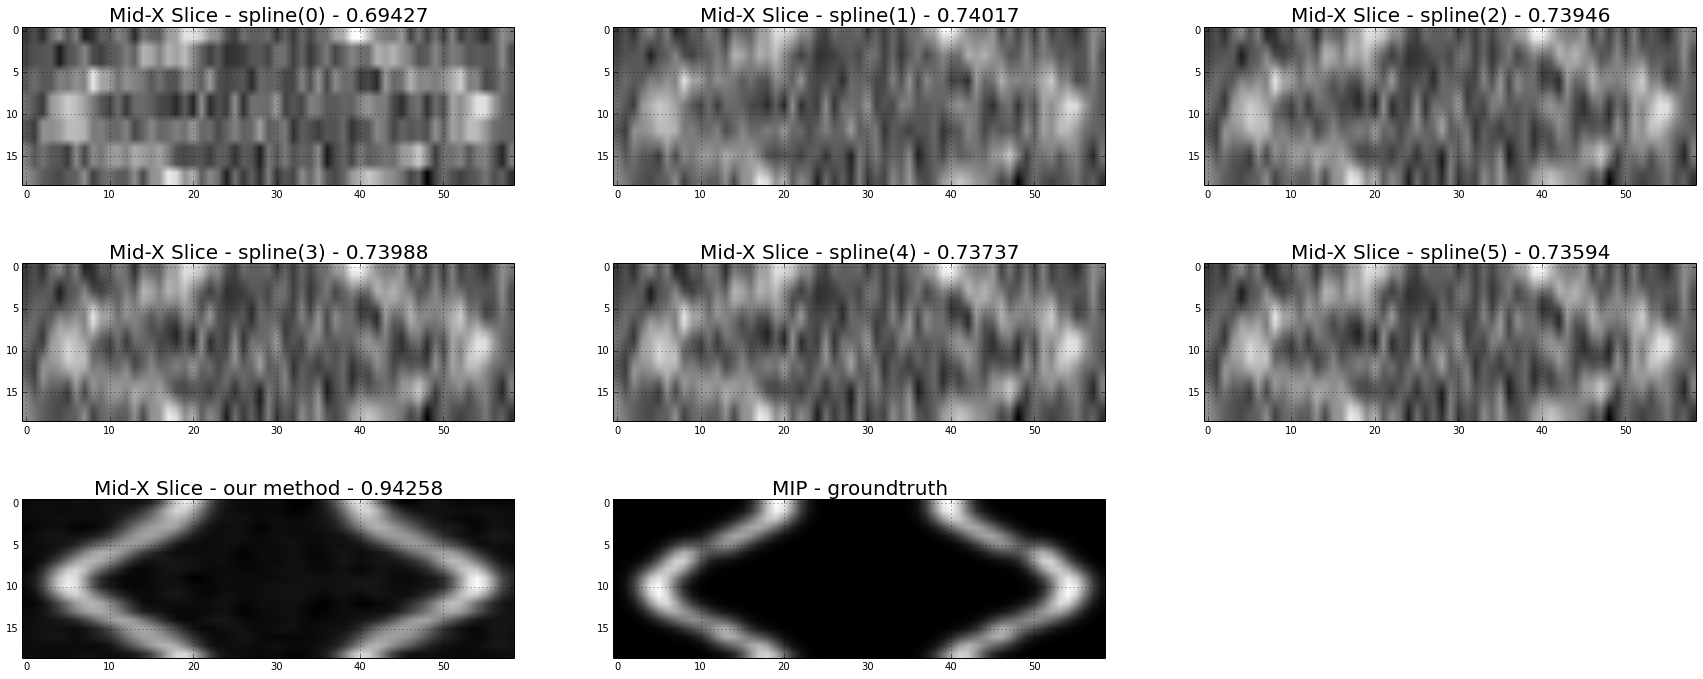

In [184]:
#
# show Mid XT slices 
#

# show result using spline interpolation
plt.figure(figsize=(30, 12))

for splineOrder in range(maxSplineOrder):
    
    # show MIP
    plt.subplot2grid((3, 3), (splineOrder/3, splineOrder%3))
    imshow(imOnePeriodVal_Spline[splineOrder][:, imOnePeriodVal_Spline[splineOrder].shape[1]/2, :].T)
    plt.title('Mid-X Slice - spline(%d) - %.5f' % (splineOrder, sim_Spline[splineOrder]), 
              fontsize=titlesize)   

# compute result using our method with RBF
sim_Our = ncorr(imOnePeriod_Groundtruth, imOnePeriodVal_Our)

plt.subplot2grid((3, 3), (2, 0))
plt.imshow(imOnePeriodVal_Our[:, imOnePeriodVal_Our.shape[1]/2, :].T)
plt.title('Mid-X Slice - our method - %.5f' % sim_Our, fontsize=titlesize)

# show groundtruth
plt.subplot2grid((3, 3), (2, 1))
plt.imshow(imOnePeriod_Groundtruth[:, imOnePeriod_Groundtruth.shape[1]/2, :].T)
plt.title('MIP - groundtruth', fontsize=titlesize)

In [108]:
# show all results together
vids = [normalizeArray(imOnePeriod_Groundtruth)]
vidlabels = ['Groundtruth']

vids.append(normalizeArray(imOnePeriodVal_Our))
vidlabels.append('Our Method') 

for splineOrder in range(maxSplineOrder):
    
    vids.append(normalizeArray(imOnePeriodVal_Spline[splineOrder]))
    vidlabels.append('Spline of order %d' % splineOrder) 

cvShowVideo(vids, vidlabels, resizeAmount=resizeAmount)

In [225]:
# write our result
writeVideoToFile(normalizeArray(imOnePeriodVal_Our), 
                 os.path.join(resultsDir, '%s.OnePeriod_Our.avi' % resultFilePrefix), 
                 codec='DIVX', fps=12)

True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146/Heart_20150220_151146.OnePeriod_Our.avi took 0.65345788002 seconds


In [226]:
# write spline result
for splineOrder in range(maxSplineOrder):
    
    writeVideoToFile(normalizeArray(imOnePeriodVal_Spline[splineOrder]), 
                     os.path.join(resultsDir, 
                                  '%s.OnePeriod_Spline-ord-%d.avi' % (resultFilePrefix, splineOrder)), 
                     codec='DIVX', fps=12)


True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146/Heart_20150220_151146.OnePeriod_Spline-ord-0.avi took 0.18816781044 seconds
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146/Heart_20150220_151146.OnePeriod_Spline-ord-1.avi took 0.220414161682 seconds
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146/Heart_20150220_151146.OnePeriod_Spline-ord-2.avi took 0.213487148285 seconds
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146/Heart_20150220_151146.OnePeriod_Spline-ord-3.avi took 0.367905139923 seconds
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146/Hea